<a href="https://colab.research.google.com/github/anomara1/BTGP/blob/main/audio_specific_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

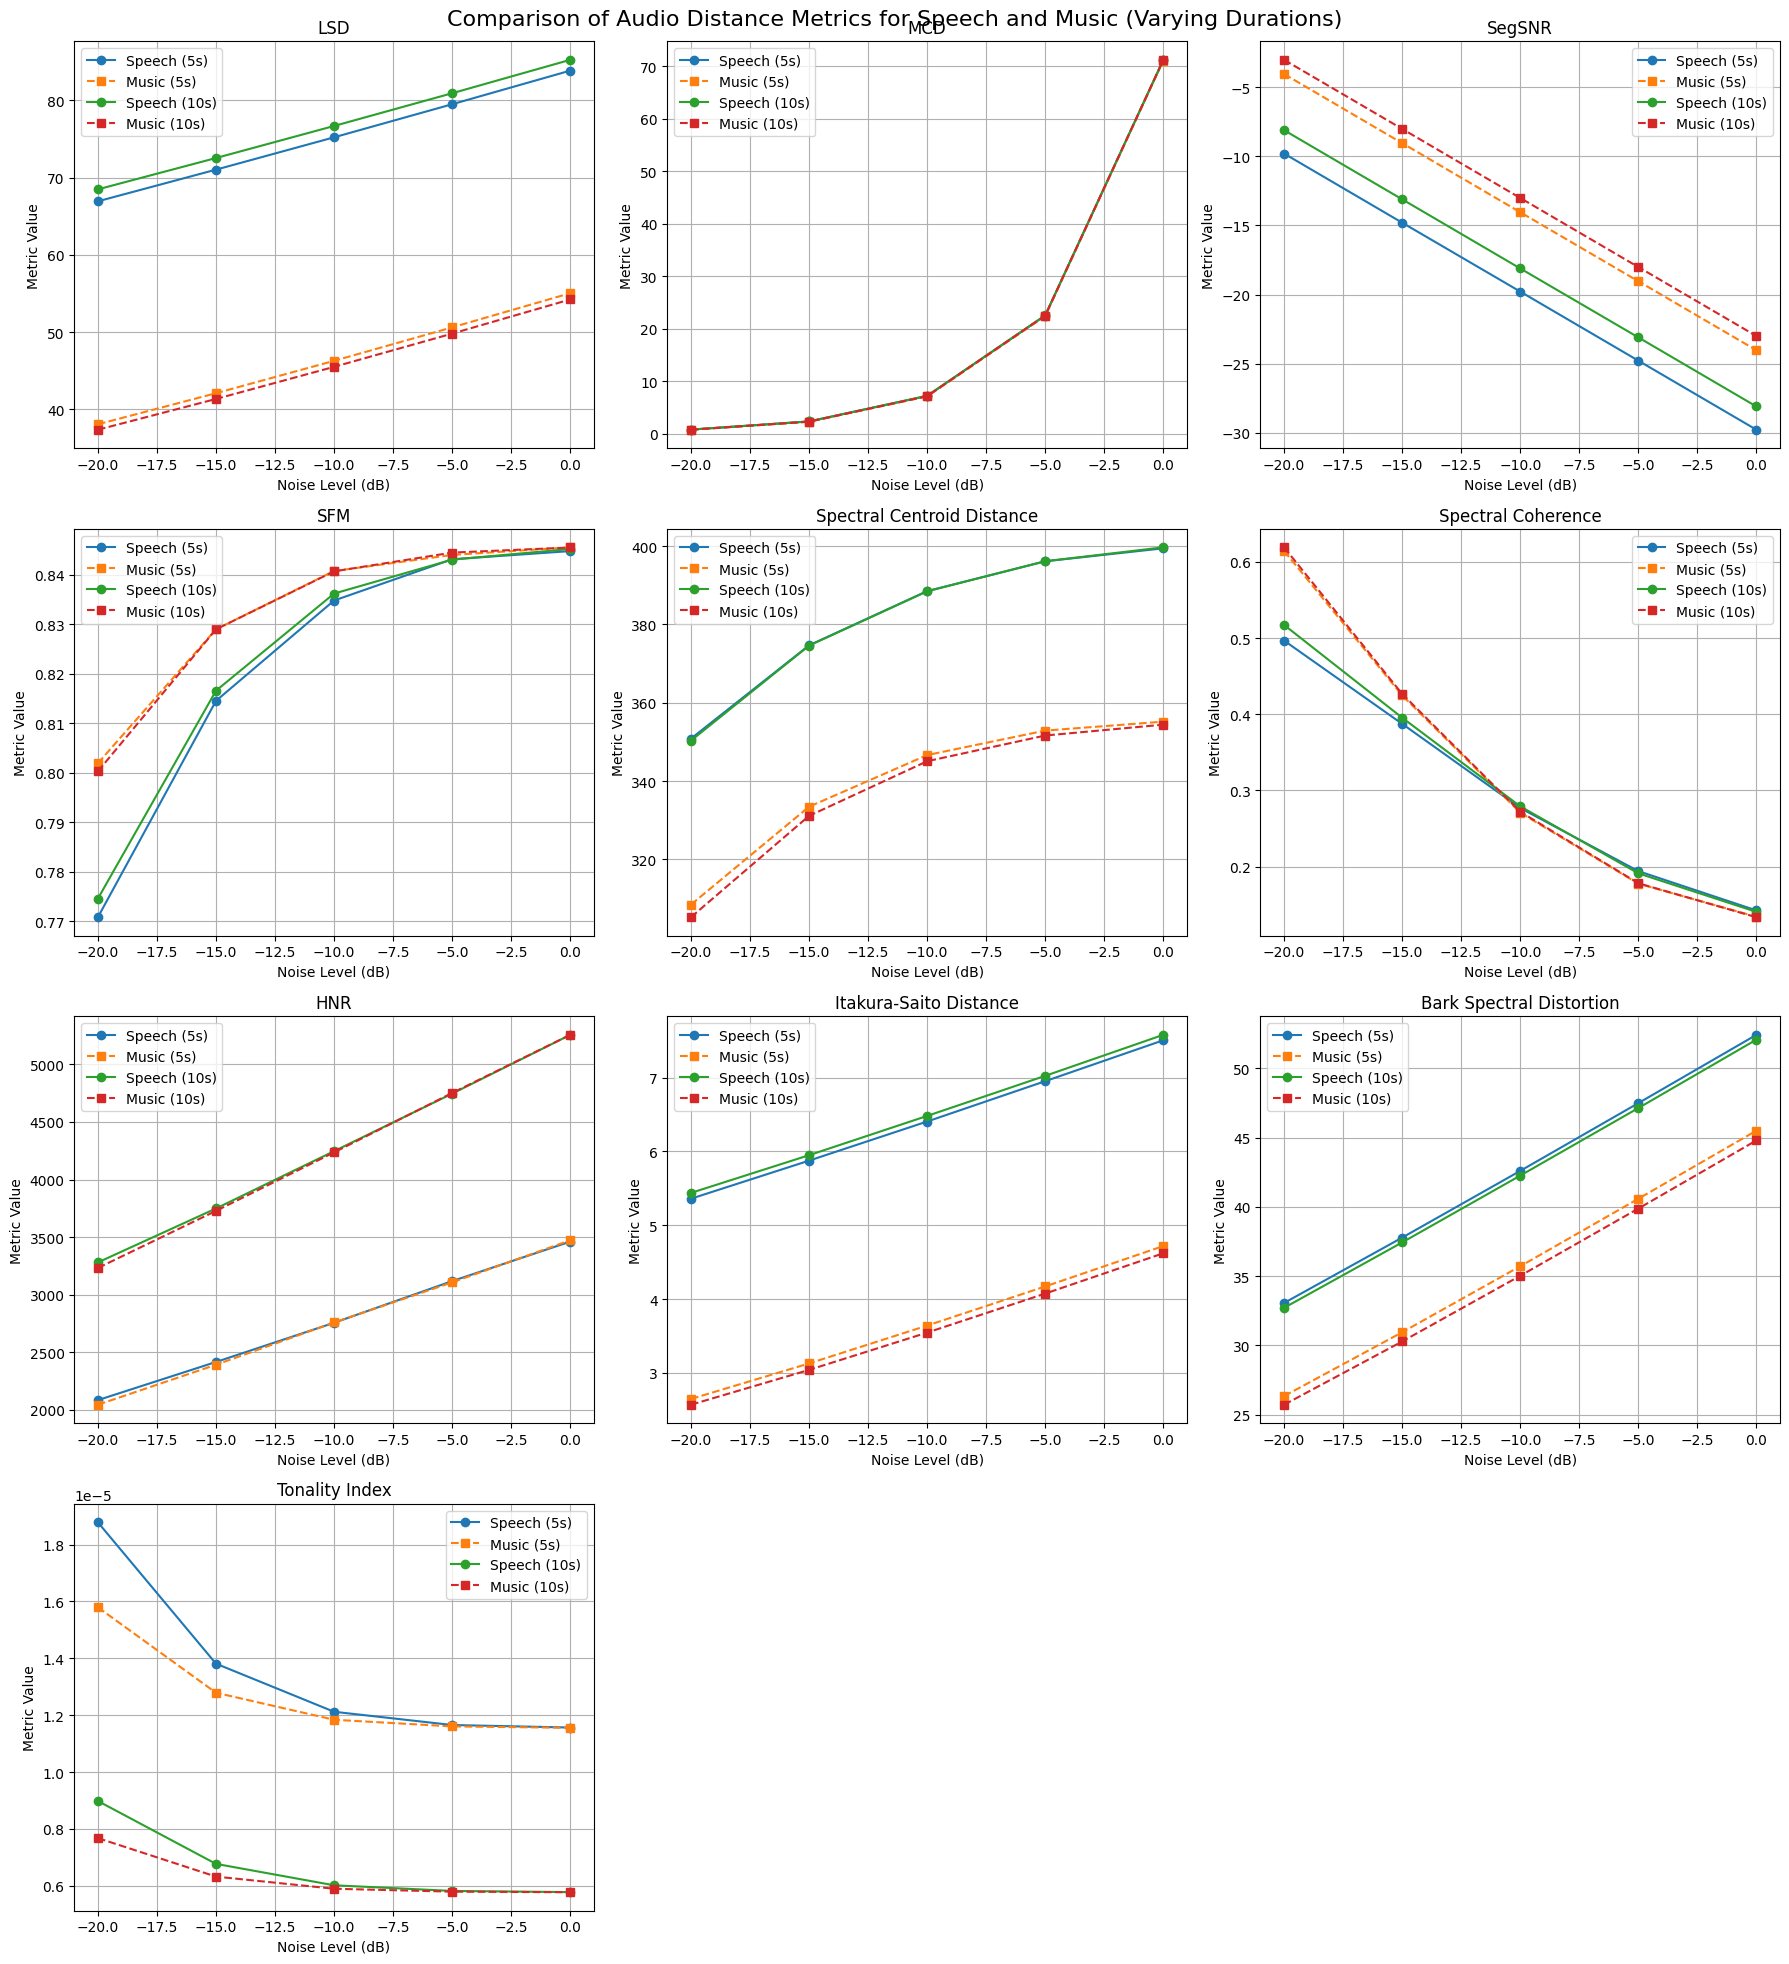

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time

# Define durations to test (in seconds)
durations = [5, 10]

# Number of signals
num_signals = 10

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

results_music = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0))
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / np.mean(np.abs(cepstrum))
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    return np.mean((X / Y) - np.log(X / Y) - 1)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X)
    Y_bark = librosa.amplitude_to_db(Y)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / np.sum(spectrum)**2
    return tonal

# Loop through different durations
for duration in durations:
    for signal_idx in range(num_signals):
        # Load a clean speech signal
        speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None, duration=duration)

        # Load a music signal
        music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None, duration=duration)

        # Resample music signal to match speech signal's sample rate
        if sr_speech != sr_music:
            music_signal = librosa.resample(music_signal, orig_sr=sr_music, target_sr=sr_speech)

        # Add noise and compute metrics for speech signal
        for noise_level in noise_levels:
            # Add noise to the speech signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal))
            noisy_speech = speech_signal + noise

            # Compute STFTs
            clean_stft_speech = np.abs(librosa.stft(speech_signal))
            noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

            # Compute metrics for speech
            results_speech['LSD'][duration].append(log_spectral_distance(clean_stft_speech, noisy_stft_speech))
            results_speech['MCD'][duration].append(mel_cepstral_distortion(speech_signal, noisy_speech))
            results_speech['SegSNR'][duration].append(segmental_snr(speech_signal, noisy_speech))
            results_speech['SFM'][duration].append(spectral_flatness_measure(noisy_speech))
            results_speech['Spectral Centroid Distance'][duration].append(spectral_centroid_distance(clean_stft_speech, noisy_stft_speech))
            results_speech['Spectral Coherence'][duration].append(spectral_coherence(speech_signal, noisy_speech))
            results_speech['HNR'][duration].append(harmonic_to_noise_ratio(noisy_speech))
            results_speech['Itakura-Saito Distance'][duration].append(itakura_saito_distance(clean_stft_speech, noisy_stft_speech))
            results_speech['Bark Spectral Distortion'][duration].append(bark_spectral_distortion(clean_stft_speech, noisy_stft_speech))
            results_speech['Tonality Index'][duration].append(tonality_index(noisy_speech))

        # Add noise and compute metrics for music signal
        for noise_level in noise_levels:
            # Add noise to the music signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal))
            noisy_music = music_signal + noise

            # Compute STFTs
            clean_stft_music = np.abs(librosa.stft(music_signal))
            noisy_stft_music = np.abs(librosa.stft(noisy_music))

            # Compute metrics for music
            results_music['LSD'][duration].append(log_spectral_distance(clean_stft_music, noisy_stft_music))
            results_music['MCD'][duration].append(mel_cepstral_distortion(music_signal, noisy_music))
            results_music['SegSNR'][duration].append(segmental_snr(music_signal, noisy_music))
            results_music['SFM'][duration].append(spectral_flatness_measure(noisy_music))
            results_music['Spectral Centroid Distance'][duration].append(spectral_centroid_distance(clean_stft_music, noisy_stft_music))
            results_music['Spectral Coherence'][duration].append(spectral_coherence(music_signal, noisy_music))
            results_music['HNR'][duration].append(harmonic_to_noise_ratio(noisy_music))
            results_music['Itakura-Saito Distance'][duration].append(itakura_saito_distance(clean_stft_music, noisy_stft_music))
            results_music['Bark Spectral Distortion'][duration].append(bark_spectral_distortion(clean_stft_music, noisy_stft_music))
            results_music['Tonality Index'][duration].append(tonality_index(noisy_music))

# Average the results for each metric and duration
for metric in results_speech.keys():
    for duration in durations:
        # Reshape the results to match the shape of noise_levels
        results_speech[metric][duration] = np.mean(np.array(results_speech[metric][duration]).reshape(num_signals, len(noise_levels)), axis=0)
        results_music[metric][duration] = np.mean(np.array(results_music[metric][duration]).reshape(num_signals, len(noise_levels)), axis=0)

# Create subplots for each metric and duration
fig, axes = plt.subplots(4, 3, figsize=(18, 20))  # 4x3 grid of subplots
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (Varying Durations)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    for duration in durations:
        axes[i].plot(noise_levels, results_speech[metric][duration], marker='o', linestyle='-', label=f'Speech ({duration}s)')
        axes[i].plot(noise_levels, results_music[metric][duration], marker='s', linestyle='--', label=f'Music ({duration}s)')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

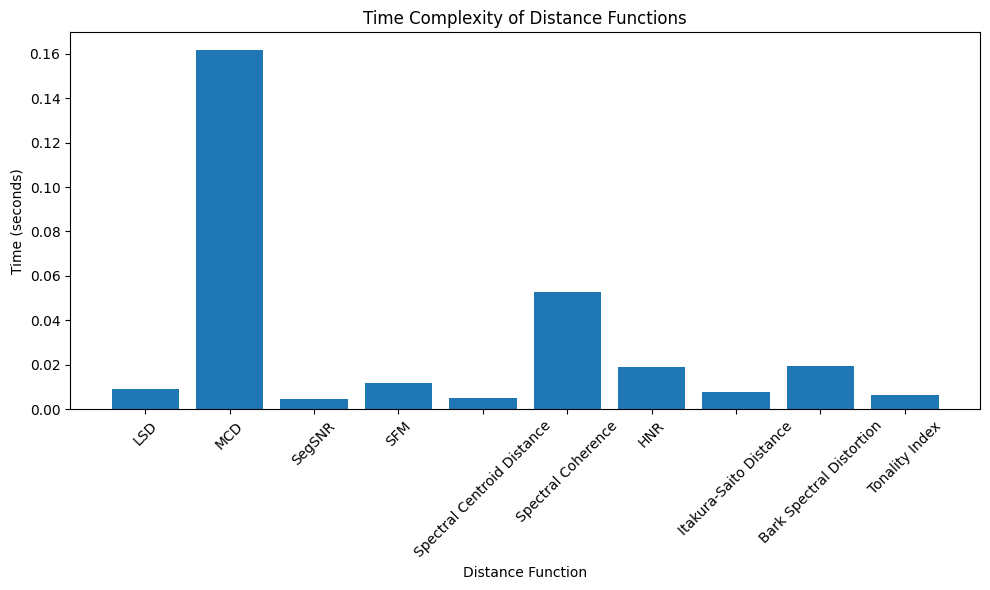

In [7]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time

# Define durations to test (in seconds)
durations = [5, 10]

# Number of signals
num_signals = 10

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

results_music = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0))
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / np.mean(np.abs(cepstrum))
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    return np.mean((X / Y) - np.log(X / Y) - 1)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X)
    Y_bark = librosa.amplitude_to_db(Y)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / np.sum(spectrum)**2
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through different durations
for duration in durations:
    for signal_idx in range(num_signals):
        # Load a clean speech signal
        speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None, duration=duration)

        # Load a music signal
        music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None, duration=duration)

        # Resample music signal to match speech signal's sample rate
        if sr_speech != sr_music:
            music_signal = librosa.resample(music_signal, orig_sr=sr_music, target_sr=sr_speech)

        # Add noise and compute metrics for speech signal
        for noise_level in noise_levels:
            # Add noise to the speech signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal))
            noisy_speech = speech_signal + noise

            # Compute STFTs
            clean_stft_speech = np.abs(librosa.stft(speech_signal))
            noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

            # Compute metrics for speech
            for metric, func in distance_functions.items():
                if metric in ['SFM', 'HNR', 'Tonality Index']:
                    # Functions that take only one argument (noisy signal)
                    start_time = time.time()
                    func(noisy_speech)
                    end_time = time.time()
                else:
                    # Functions that take two arguments (clean and noisy signals)
                    start_time = time.time()
                    func(clean_stft_speech, noisy_stft_speech)
                    end_time = time.time()
                time_complexities[metric].append(end_time - start_time)

        # Add noise and compute metrics for music signal
        for noise_level in noise_levels:
            # Add noise to the music signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal))
            noisy_music = music_signal + noise

            # Compute STFTs
            clean_stft_music = np.abs(librosa.stft(music_signal))
            noisy_stft_music = np.abs(librosa.stft(noisy_music))

            # Compute metrics for music
            for metric, func in distance_functions.items():
                if metric in ['SFM', 'HNR', 'Tonality Index']:
                    # Functions that take only one argument (noisy signal)
                    start_time = time.time()
                    func(noisy_music)
                    end_time = time.time()
                else:
                    # Functions that take two arguments (clean and noisy signals)
                    start_time = time.time()
                    func(clean_stft_music, noisy_stft_music)
                    end_time = time.time()
                time_complexities[metric].append(end_time - start_time)

# Average the time complexities
for metric in time_complexities.keys():
    time_complexities[metric] = np.mean(time_complexities[metric])

# Plot time complexity
plt.figure(figsize=(10, 6))
plt.bar(time_complexities.keys(), time_complexities.values())
plt.xlabel('Distance Function')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of Distance Functions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=64
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


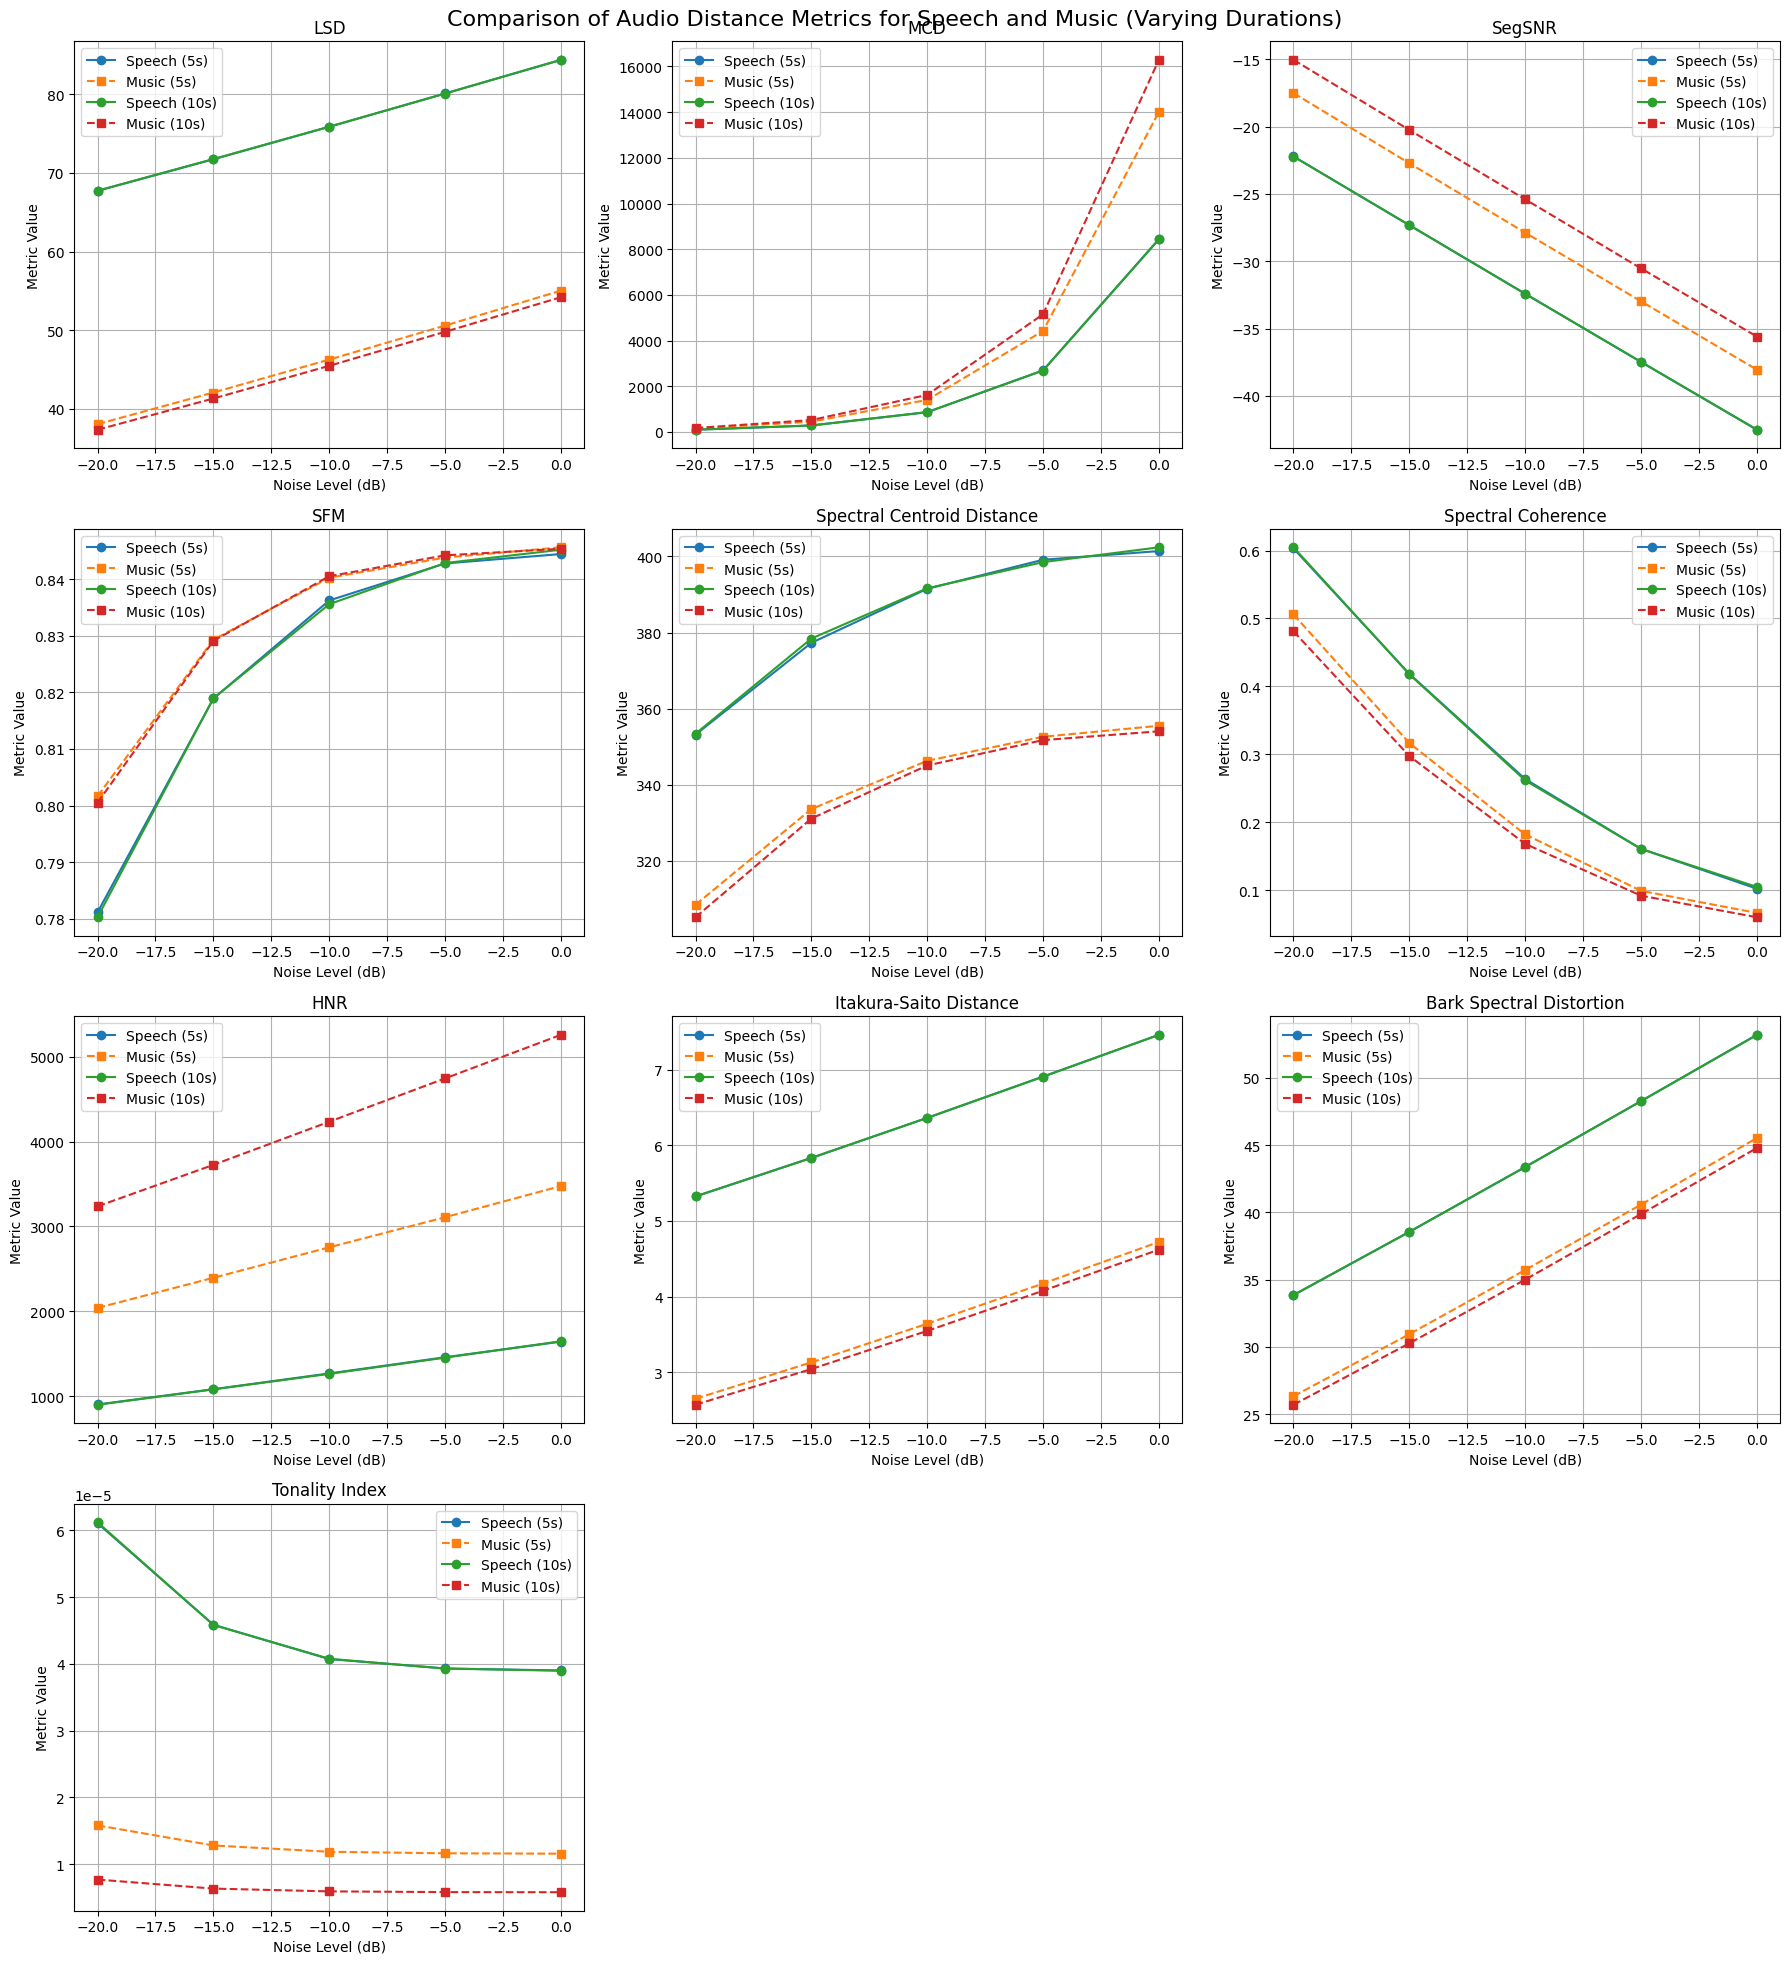

<ipython-input-8-4a2b1ec85d61>:227: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([time_complexities[metric] for metric in distance_functions.keys()], labels=distance_functions.keys())


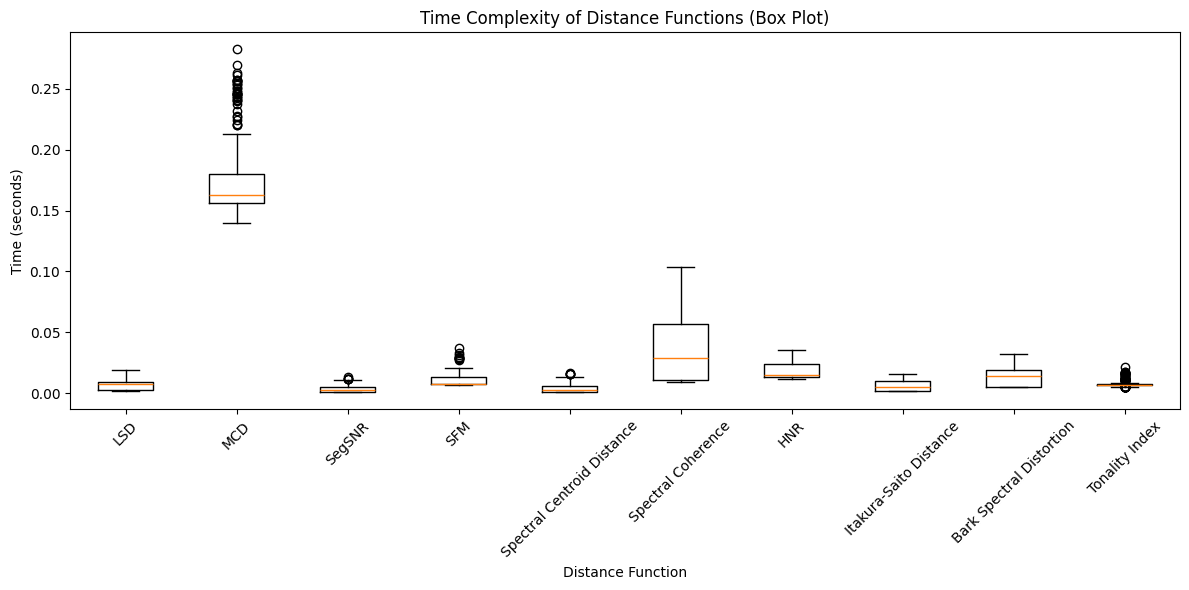

In [8]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time

# Define durations to test (in seconds)
durations = [5, 10]

# Number of signals
num_signals = 10

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 10 different segments
segment_length = len(speech_signal) // num_signals
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

results_music = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0))
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / np.mean(np.abs(cepstrum))
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    return np.mean((X / Y) - np.log(X / Y) - 1)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X)
    Y_bark = librosa.amplitude_to_db(Y)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / np.sum(spectrum)**2
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through different durations
for duration in durations:
    for signal_idx in range(num_signals):
        # Use a different segment of the speech signal
        speech_signal_segment = speech_segments[signal_idx][:int(duration * sr_speech)]

        # Load a music signal
        music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None, duration=duration)

        # Resample music signal to match speech signal's sample rate
        if sr_speech != sr_music:
            music_signal = librosa.resample(music_signal, orig_sr=sr_music, target_sr=sr_speech)

        # Add noise and compute metrics for speech signal
        for noise_level in noise_levels:
            # Add noise to the speech signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
            noisy_speech = speech_signal_segment + noise

            # Compute STFTs
            clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
            noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

            # Compute metrics for speech
            for metric, func in distance_functions.items():
                if metric in ['SFM', 'HNR', 'Tonality Index']:
                    # Functions that take only one argument (noisy signal)
                    start_time = time.time()
                    result = func(noisy_speech)
                    end_time = time.time()
                else:
                    # Functions that take two arguments (clean and noisy signals)
                    start_time = time.time()
                    result = func(clean_stft_speech, noisy_stft_speech)
                    end_time = time.time()
                time_complexities[metric].append(end_time - start_time)
                results_speech[metric][duration].append(result)

        # Add noise and compute metrics for music signal
        for noise_level in noise_levels:
            # Add noise to the music signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal))
            noisy_music = music_signal + noise

            # Compute STFTs
            clean_stft_music = np.abs(librosa.stft(music_signal))
            noisy_stft_music = np.abs(librosa.stft(noisy_music))

            # Compute metrics for music
            for metric, func in distance_functions.items():
                if metric in ['SFM', 'HNR', 'Tonality Index']:
                    # Functions that take only one argument (noisy signal)
                    start_time = time.time()
                    result = func(noisy_music)
                    end_time = time.time()
                else:
                    # Functions that take two arguments (clean and noisy signals)
                    start_time = time.time()
                    result = func(clean_stft_music, noisy_stft_music)
                    end_time = time.time()
                time_complexities[metric].append(end_time - start_time)
                results_music[metric][duration].append(result)

# Average the results for each metric and duration
for metric in results_speech.keys():
    for duration in durations:
        results_speech[metric][duration] = np.mean(np.array(results_speech[metric][duration]).reshape(num_signals, len(noise_levels)), axis=0)
        results_music[metric][duration] = np.mean(np.array(results_music[metric][duration]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (Varying Durations)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    for duration in durations:
        axes[i].plot(noise_levels, results_speech[metric][duration], marker='o', linestyle='-', label=f'Speech ({duration}s)')
        axes[i].plot(noise_levels, results_music[metric][duration], marker='s', linestyle='--', label=f'Music ({duration}s)')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot time complexity as box plots
plt.figure(figsize=(12, 6))
plt.boxplot([time_complexities[metric] for metric in distance_functions.keys()], labels=distance_functions.keys())
plt.xlabel('Distance Function')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of Distance Functions (Box Plot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=7
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 7, using nperseg = 7
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=20
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 20, using nperseg = 20
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


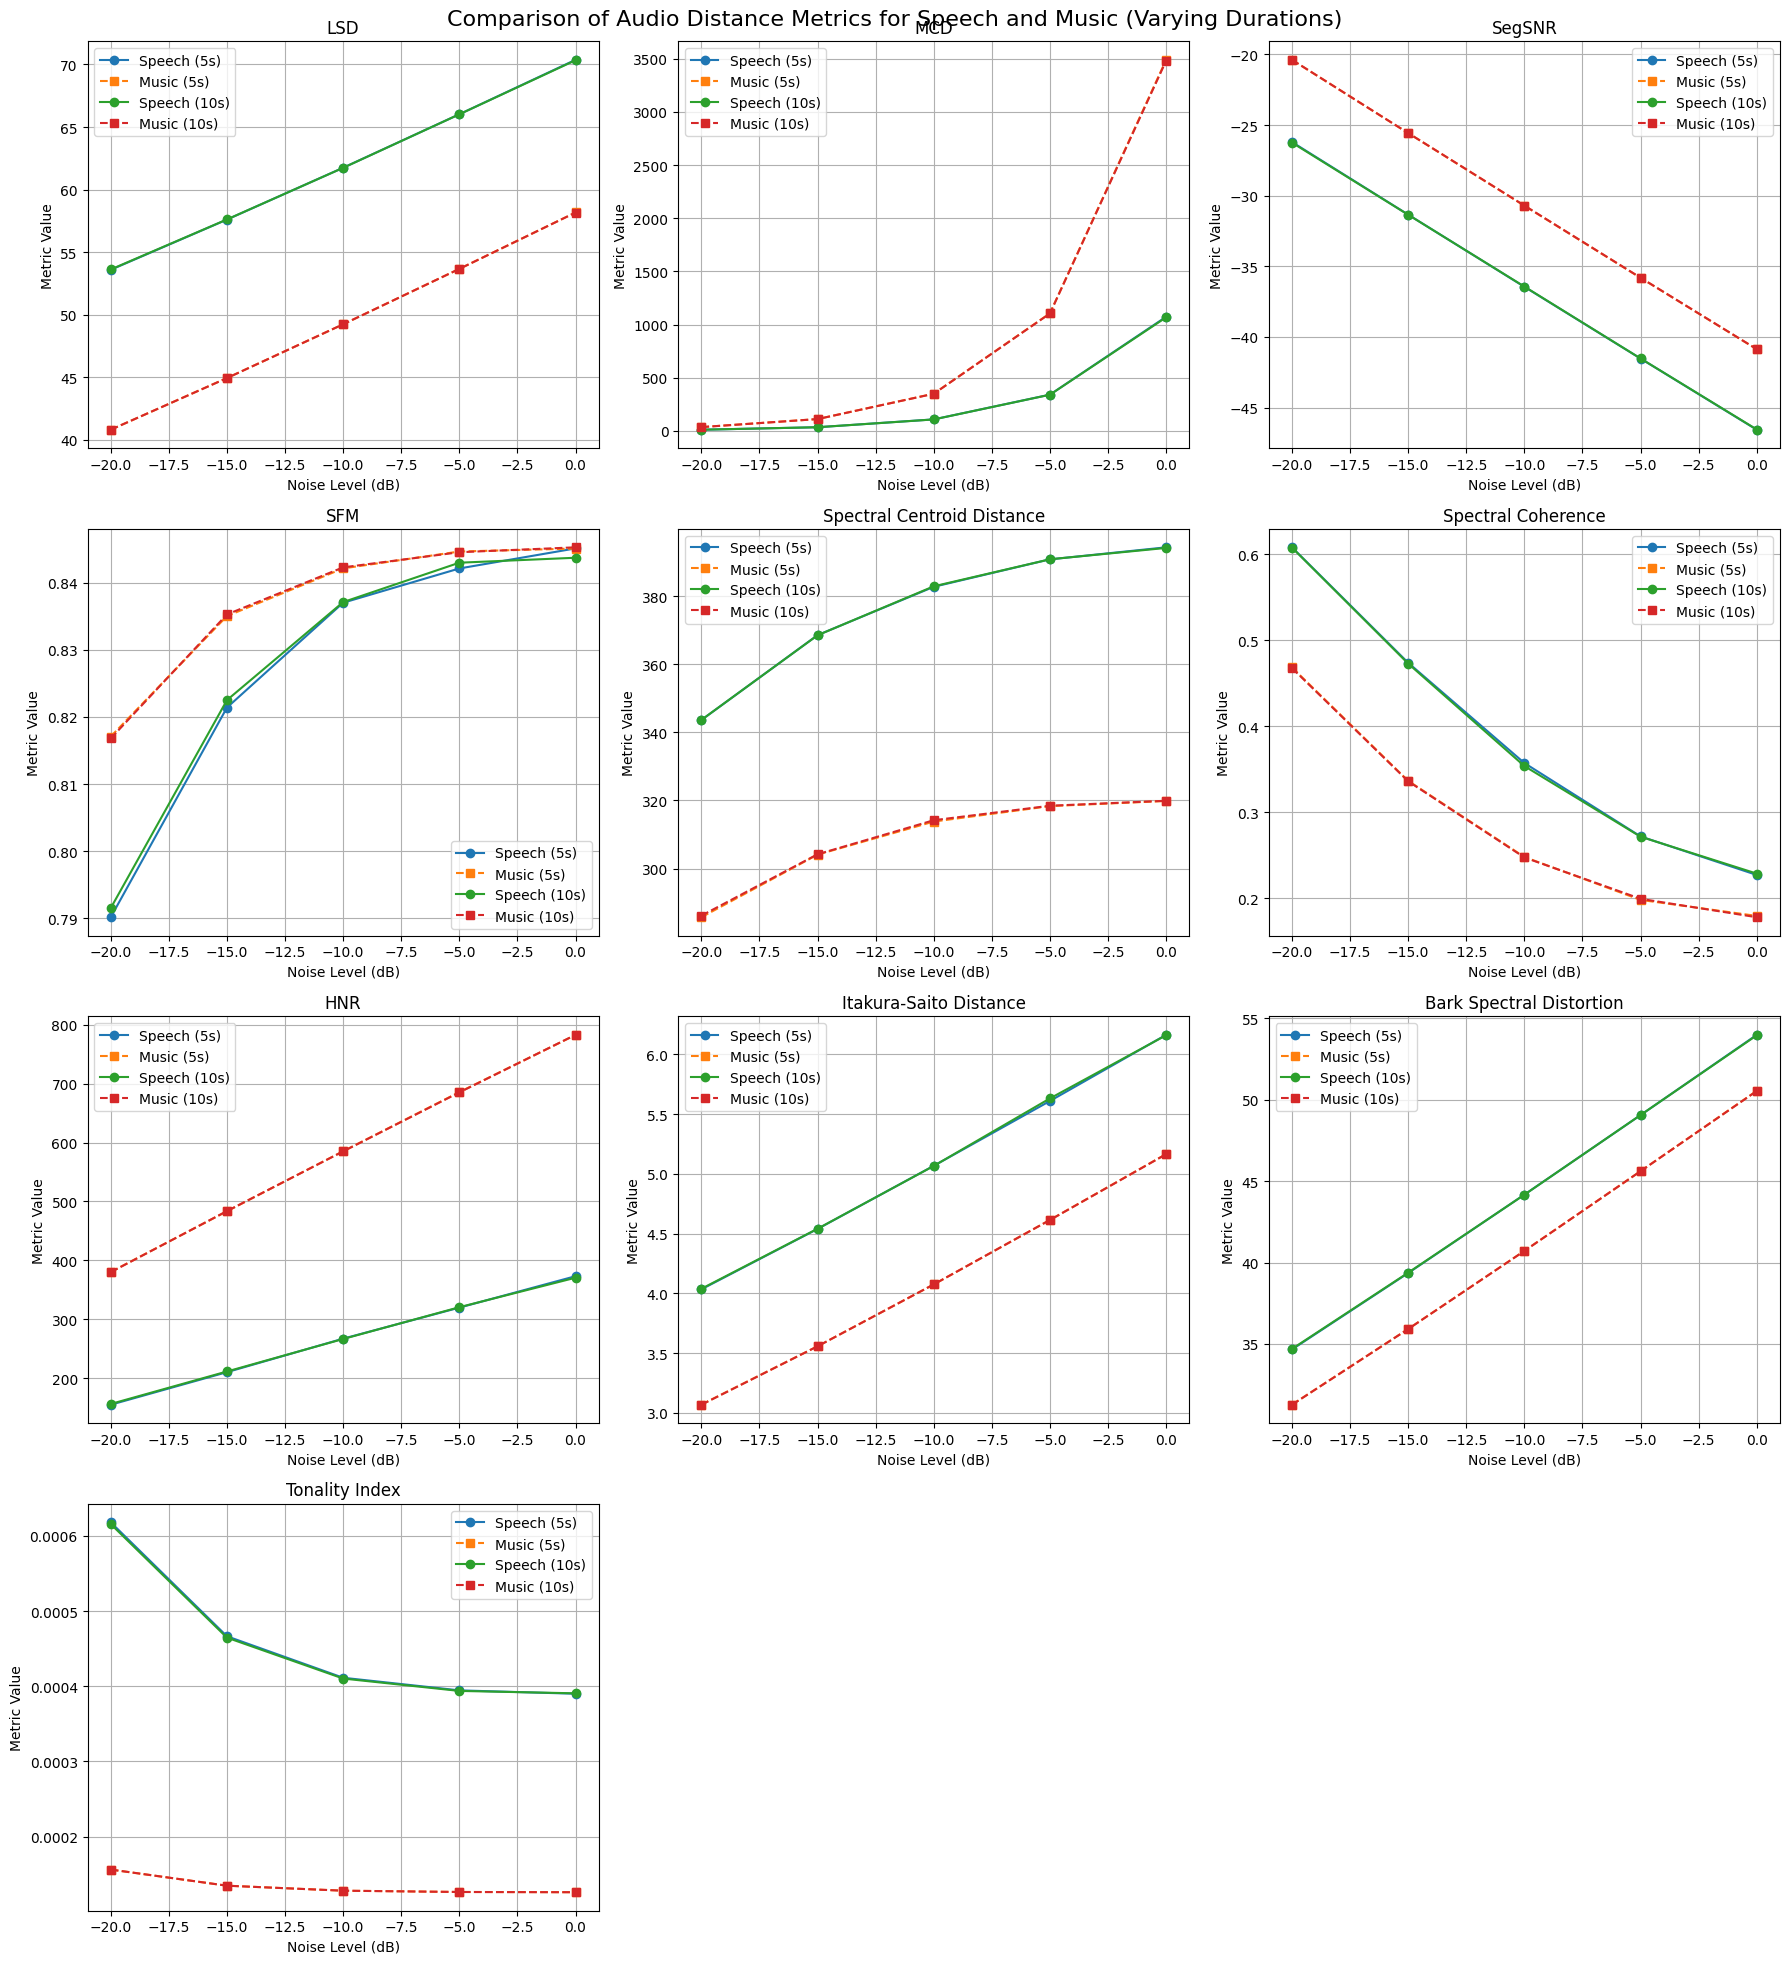

<ipython-input-9-364feec56aca>:234: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([time_complexities[metric] for metric in distance_functions.keys()], labels=distance_functions.keys())


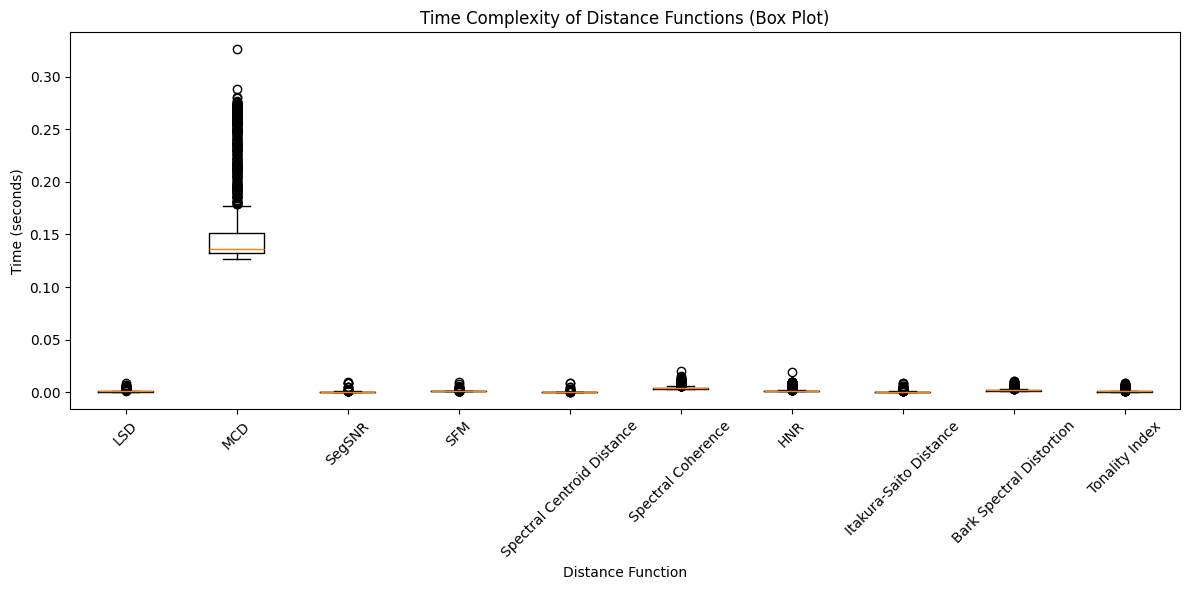

In [9]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time

# Define durations to test (in seconds)
durations = [5, 10]

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments
segment_length = len(speech_signal) // num_signals
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments
segment_length_music = len(music_signal) // num_signals
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

results_music = {
    'LSD': {duration: [] for duration in durations},
    'MCD': {duration: [] for duration in durations},
    'SegSNR': {duration: [] for duration in durations},
    'SFM': {duration: [] for duration in durations},
    'Spectral Centroid Distance': {duration: [] for duration in durations},
    'Spectral Coherence': {duration: [] for duration in durations},
    'HNR': {duration: [] for duration in durations},
    'Itakura-Saito Distance': {duration: [] for duration in durations},
    'Bark Spectral Distortion': {duration: [] for duration in durations},
    'Tonality Index': {duration: [] for duration in durations}
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0))
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / np.mean(np.abs(cepstrum))
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    return np.mean((X / Y) - np.log(X / Y) - 1)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X)
    Y_bark = librosa.amplitude_to_db(Y)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / np.sum(spectrum)**2
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through different durations
for duration in durations:
    for signal_idx in range(num_signals):
        # Use a different segment of the speech signal
        speech_signal_segment = speech_segments[signal_idx][:int(duration * sr_speech)]

        # Use a different segment of the music signal
        music_signal_segment = music_segments[signal_idx][:int(duration * sr_music)]

        # Resample music signal to match speech signal's sample rate
        if sr_speech != sr_music:
            music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

        # Add noise and compute metrics for speech signal
        for noise_level in noise_levels:
            # Add noise to the speech signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
            noisy_speech = speech_signal_segment + noise

            # Compute STFTs
            clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
            noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

            # Compute metrics for speech
            for metric, func in distance_functions.items():
                if metric in ['SFM', 'HNR', 'Tonality Index']:
                    # Functions that take only one argument (noisy signal)
                    start_time = time.time()
                    result = func(noisy_speech)
                    end_time = time.time()
                else:
                    # Functions that take two arguments (clean and noisy signals)
                    start_time = time.time()
                    result = func(clean_stft_speech, noisy_stft_speech)
                    end_time = time.time()
                time_complexities[metric].append(end_time - start_time)
                results_speech[metric][duration].append(result)

        # Add noise and compute metrics for music signal
        for noise_level in noise_levels:
            # Add noise to the music signal
            noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
            noisy_music = music_signal_segment + noise

            # Compute STFTs
            clean_stft_music = np.abs(librosa.stft(music_signal_segment))
            noisy_stft_music = np.abs(librosa.stft(noisy_music))

            # Compute metrics for music
            for metric, func in distance_functions.items():
                if metric in ['SFM', 'HNR', 'Tonality Index']:
                    # Functions that take only one argument (noisy signal)
                    start_time = time.time()
                    result = func(noisy_music)
                    end_time = time.time()
                else:
                    # Functions that take two arguments (clean and noisy signals)
                    start_time = time.time()
                    result = func(clean_stft_music, noisy_stft_music)
                    end_time = time.time()
                time_complexities[metric].append(end_time - start_time)
                results_music[metric][duration].append(result)

# Average the results for each metric and duration
for metric in results_speech.keys():
    for duration in durations:
        results_speech[metric][duration] = np.mean(np.array(results_speech[metric][duration]).reshape(num_signals, len(noise_levels)), axis=0)
        results_music[metric][duration] = np.mean(np.array(results_music[metric][duration]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (Varying Durations)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    for duration in durations:
        axes[i].plot(noise_levels, results_speech[metric][duration], marker='o', linestyle='-', label=f'Speech ({duration}s)')
        axes[i].plot(noise_levels, results_music[metric][duration], marker='s', linestyle='--', label=f'Music ({duration}s)')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot time complexity as box plots
plt.figure(figsize=(12, 6))
plt.boxplot([time_complexities[metric] for metric in distance_functions.keys()], labels=distance_functions.keys())
plt.xlabel('Distance Function')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of Distance Functions (Box Plot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0))
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / np.mean(np.abs(cepstrum))
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    return np.mean((X / Y) - np.log(X / Y) - 1)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X)
    Y_bark = librosa.amplitude_to_db(Y)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / np.sum(spectrum)**2
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
<ipython-input-10-5c1c182d5a0d>:60: RuntimeWarning: divide by zero en

ValueError: Invalid number of FFT data points (0) specified.

<ipython-input-11-a23102748db5>:60: RuntimeWarning: divide by zero encountered in log10
  return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))
<ipython-input-11-a23102748db5>:75: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
<ipython-input-11-a23102748db5>:90: RuntimeWarning: invalid value encountered in divide
  centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
<ipython-input-11-a23102748db5>:91: RuntimeWarning: invalid value encountered in divide
  centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 1, using nperseg = 1
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
<ipython-input-11-a23102748db5>:99: RuntimeWarning

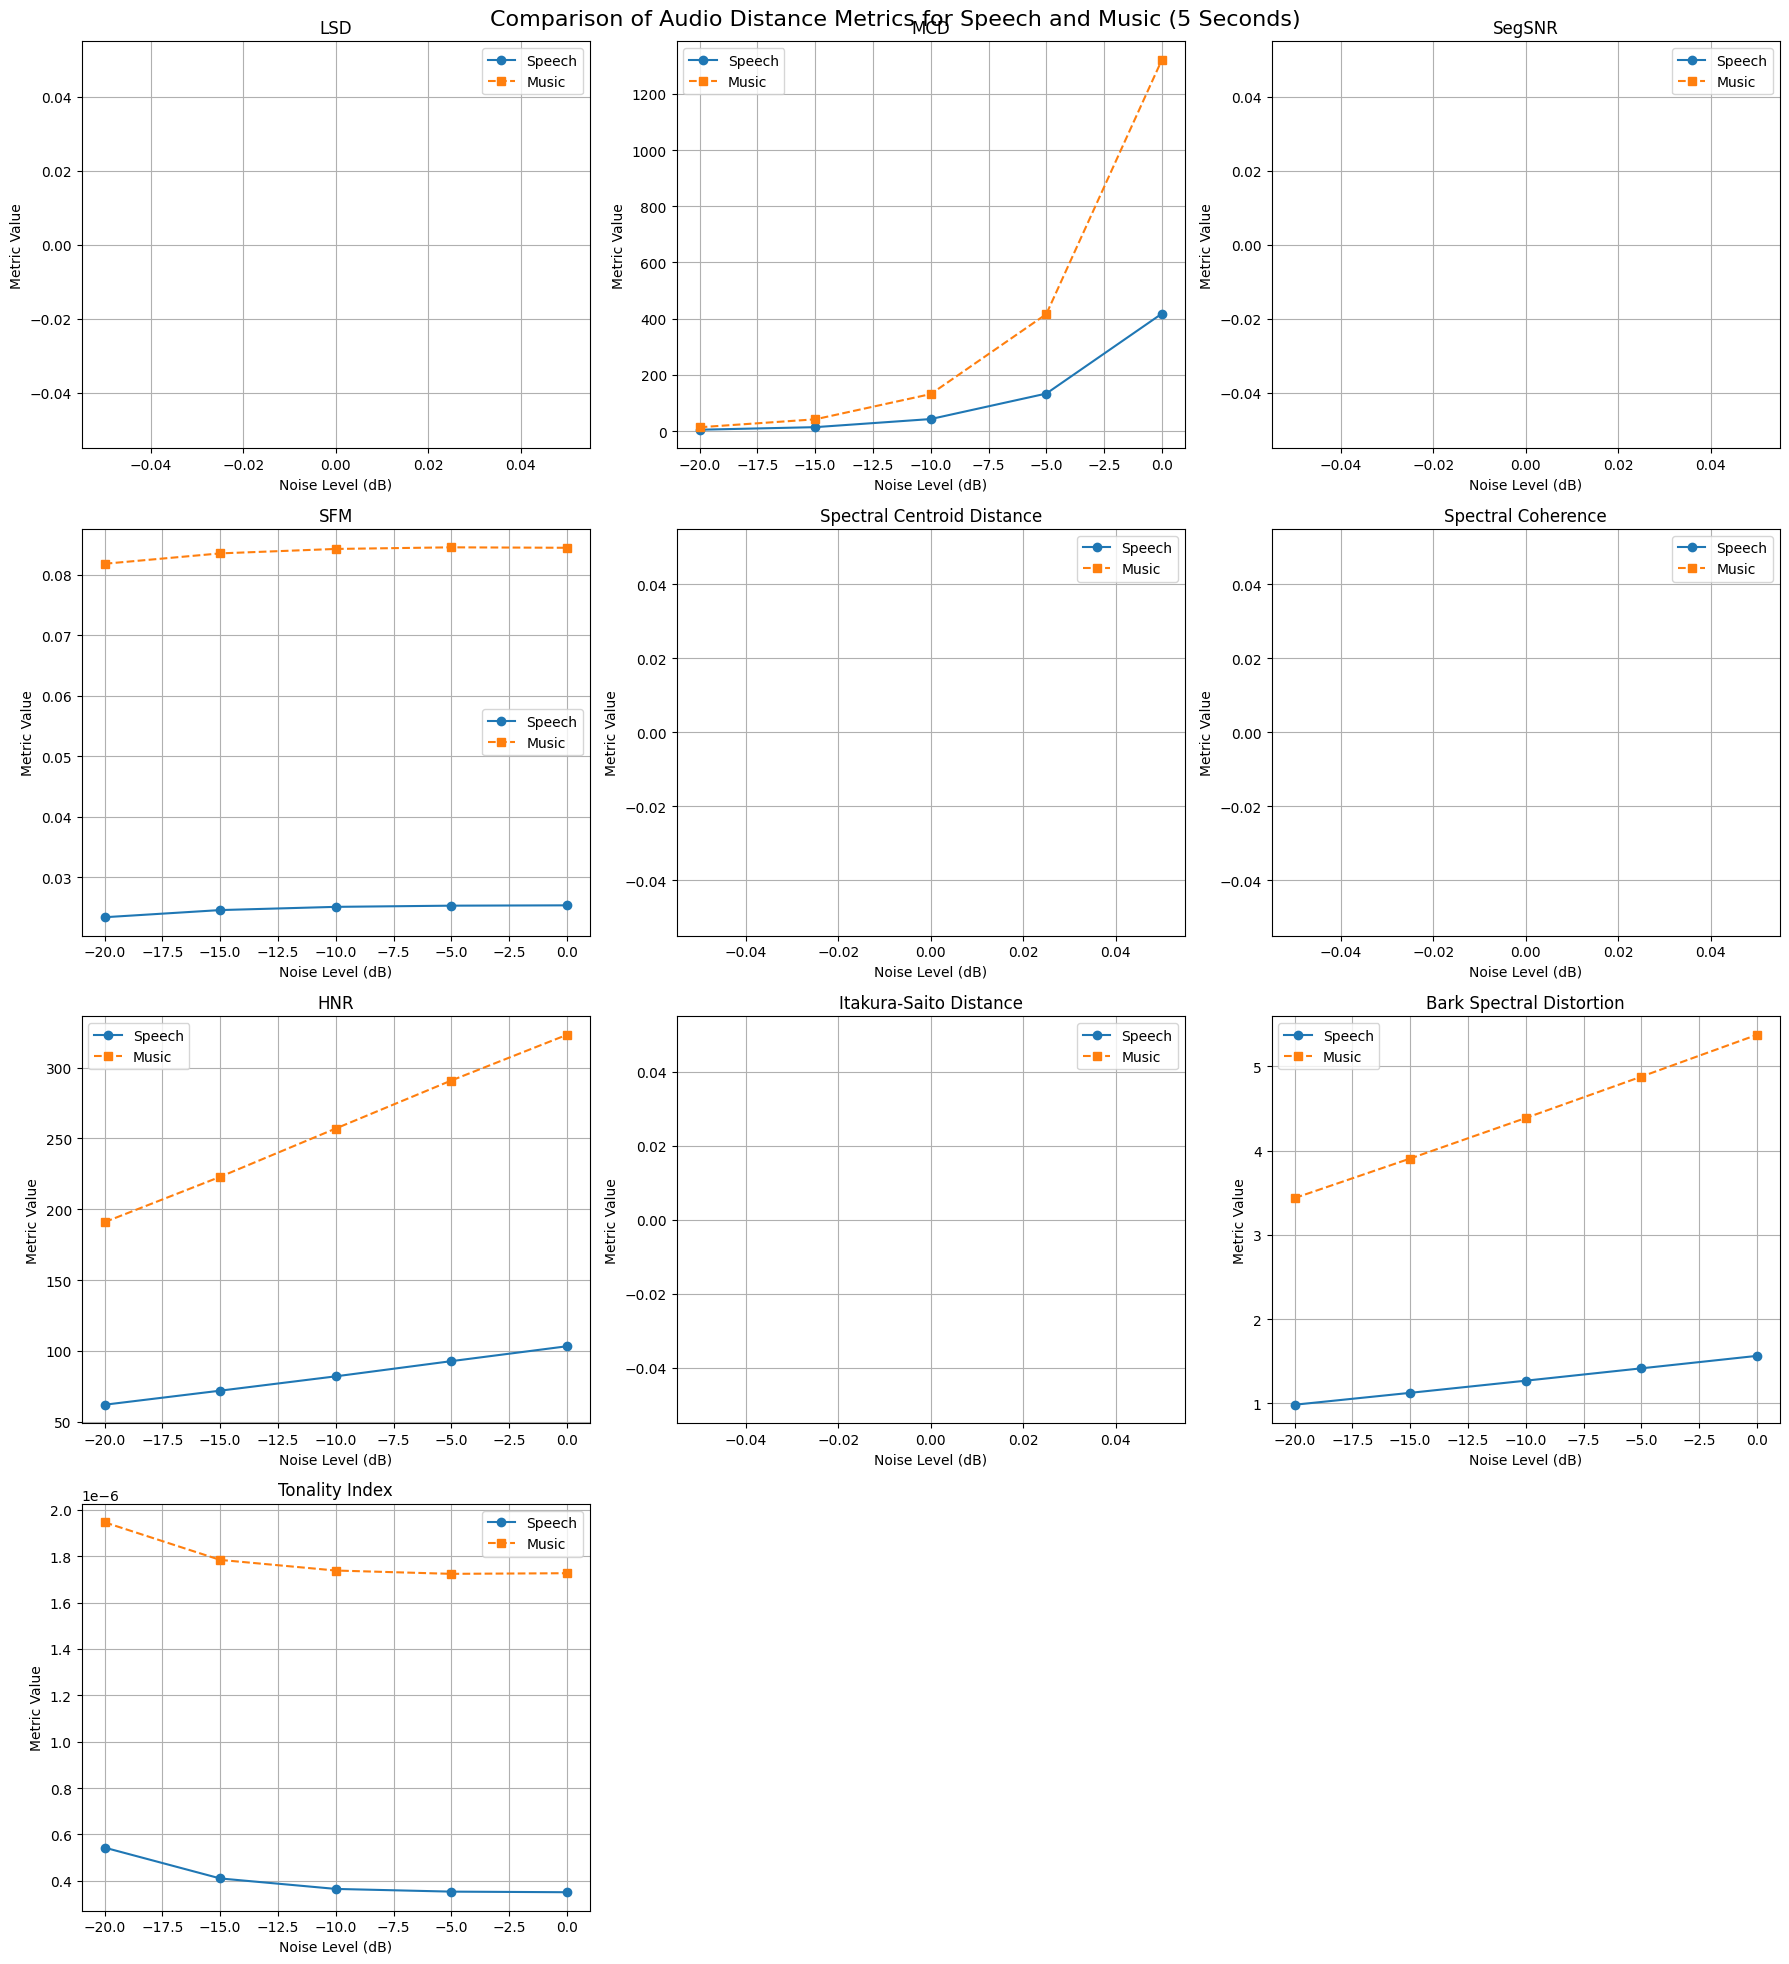

Time Complexity Table:
            Distance Function  Average Time (seconds)
0                         LSD                0.000599
1                         MCD                0.159010
2                      SegSNR                0.000532
3                         SFM                0.000480
4  Spectral Centroid Distance                0.000339
5          Spectral Coherence                0.003056
6                         HNR                0.000829
7      Itakura-Saito Distance                0.000404
8    Bark Spectral Distortion                0.001314
9              Tonality Index                0.000317


In [11]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    return np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        snr = 10 * np.log10(np.sum(clean_frame**2) / (np.sum(noise_frame**2) + 1e-10))
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / np.sum(np.abs(X), axis=0)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / np.sum(np.abs(Y), axis=0)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0))
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / np.mean(np.abs(cepstrum))
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    return np.mean((X / Y) - np.log(X / Y) - 1)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X)
    Y_bark = librosa.amplitude_to_db(Y)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / np.sum(spectrum)**2
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266:

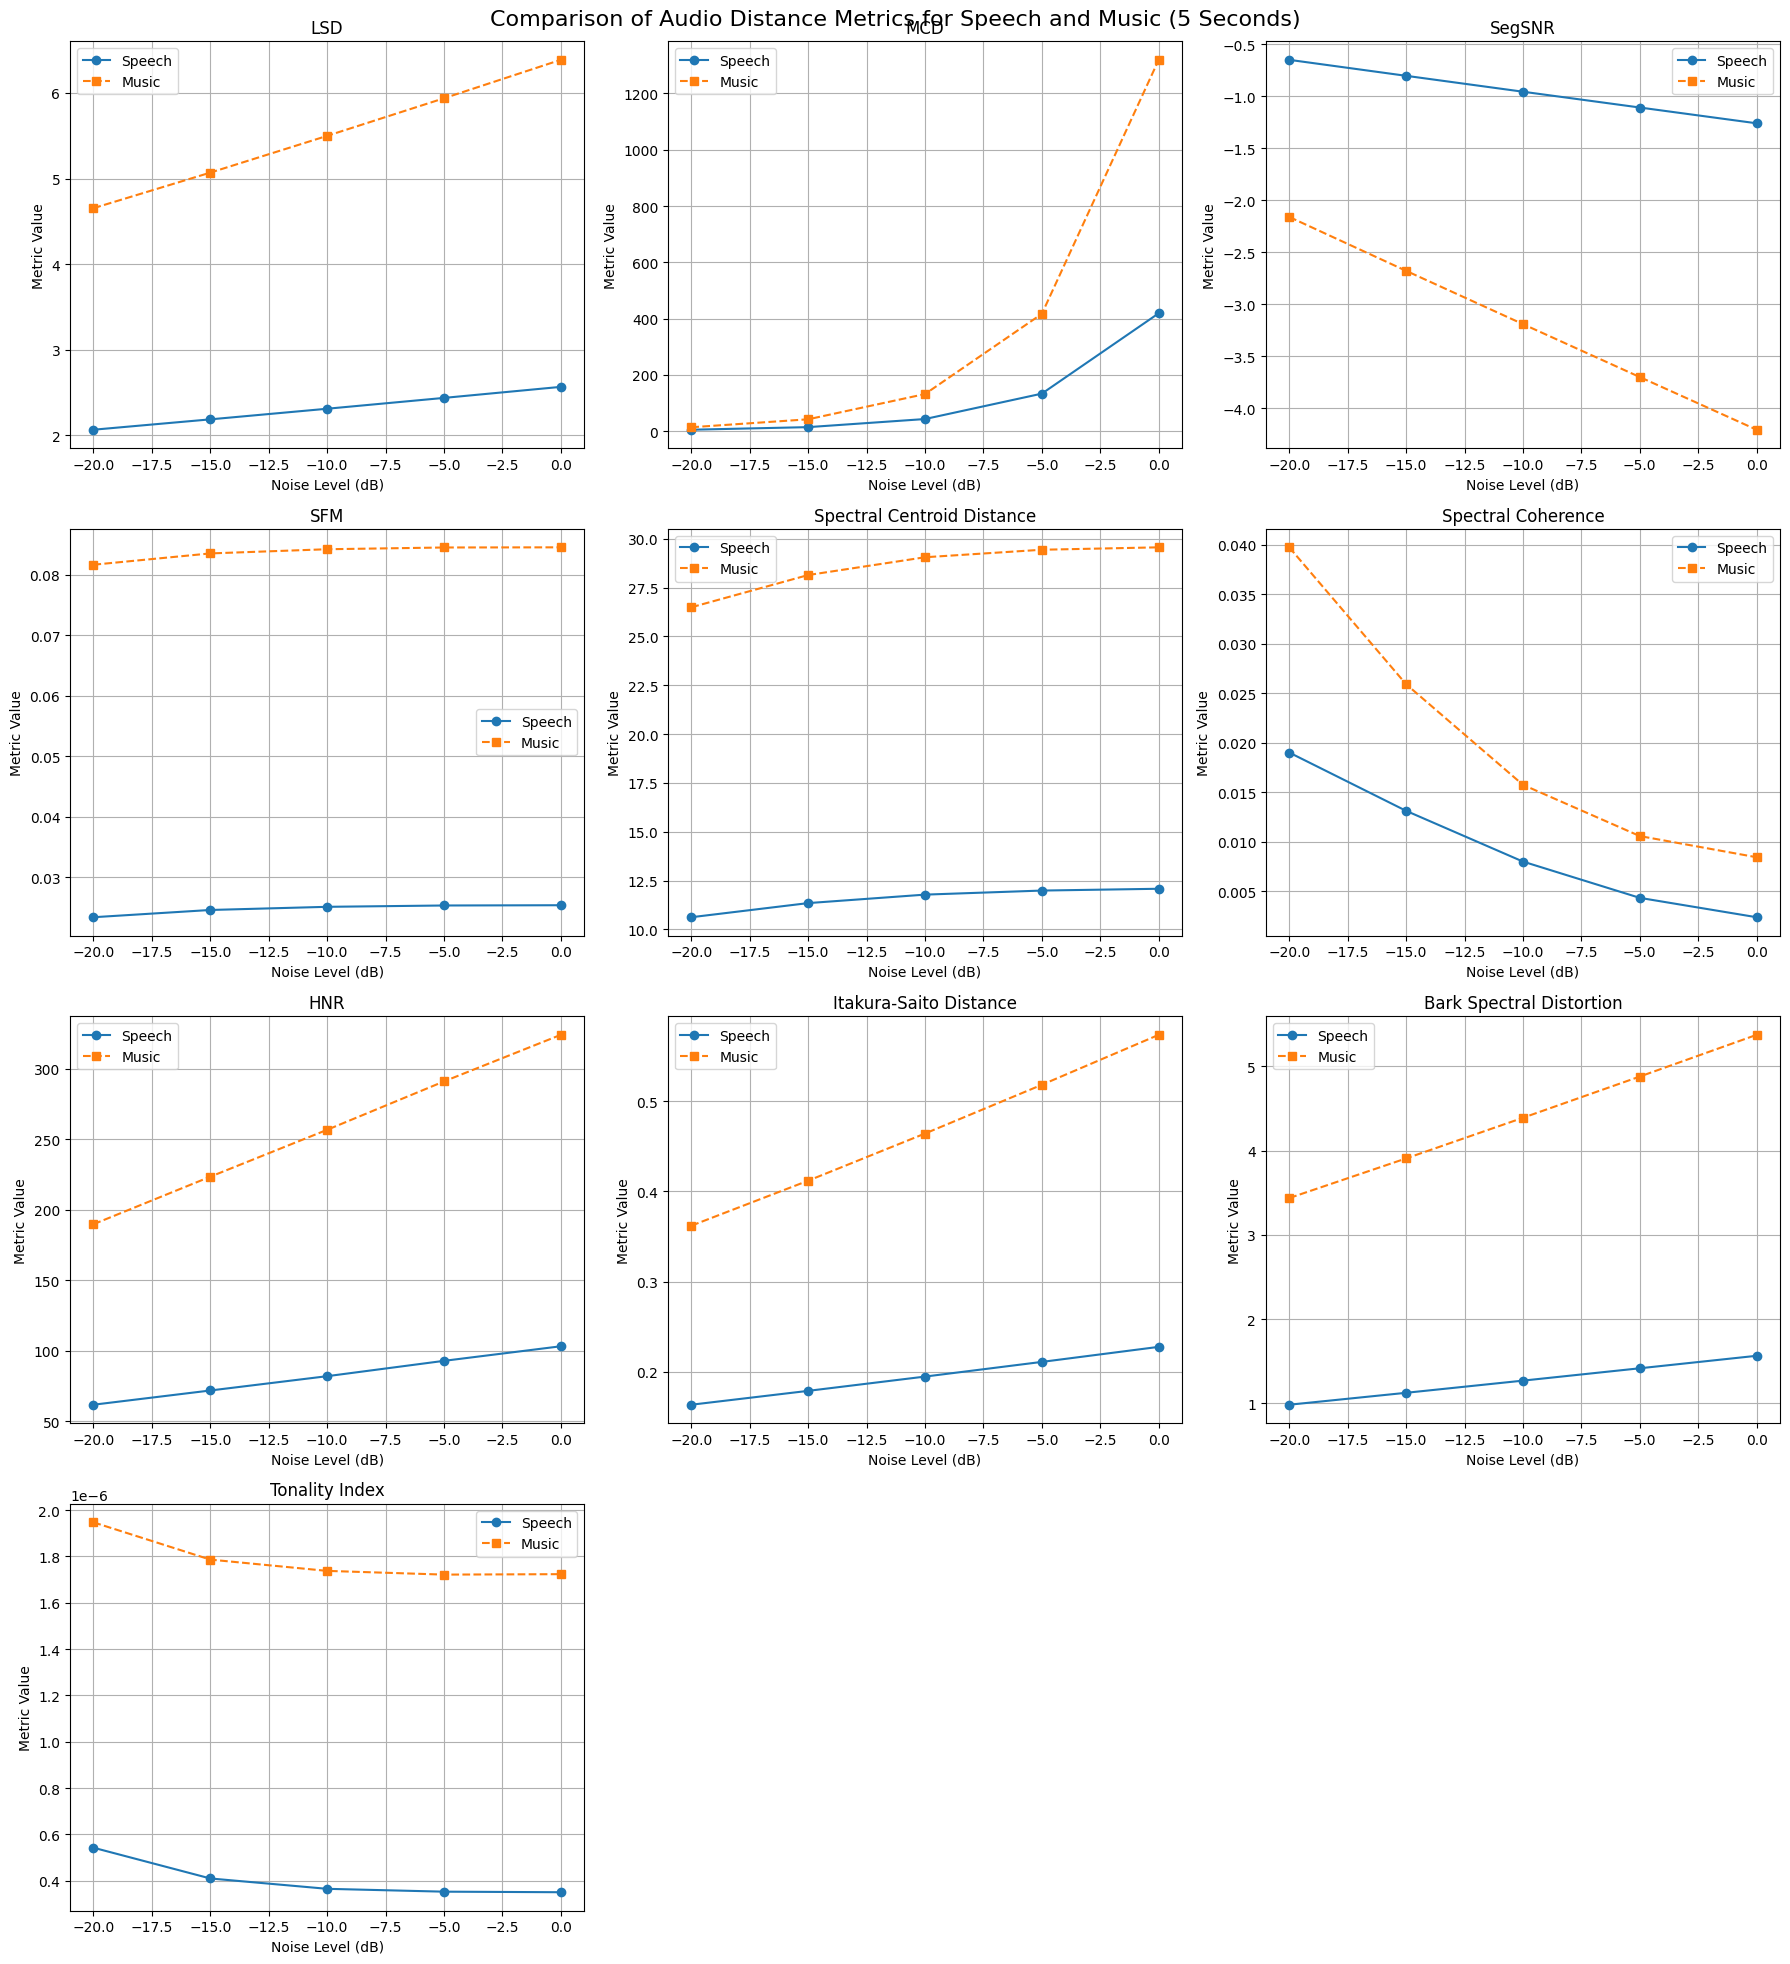

Time Complexity Table:
            Distance Function  Average Time (seconds)
0                         LSD                0.000692
1                         MCD                0.158983
2                      SegSNR                0.000459
3                         SFM                0.000582
4  Spectral Centroid Distance                0.000402
5          Spectral Coherence                0.003478
6                         HNR                0.000845
7      Itakura-Saito Distance                0.000513
8    Bark Spectral Distortion                0.001352
9              Tonality Index                0.000317


In [12]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        lsd = np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))
    return np.nan_to_num(lsd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        signal_power = np.sum(clean_frame**2)
        noise_power = np.sum(noise_frame**2)
        if noise_power == 0:
            snr = 0  # Avoid division by zero
        else:
            snr = 10 * np.log10(signal_power / noise_power)
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    if amean == 0:
        return 0  # Avoid division by zero
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / (np.sum(np.abs(X), axis=0) + 1e-10)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / (np.sum(np.abs(Y), axis=0) + 1e-10)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / (np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0)) + 1e-10)
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / (np.mean(np.abs(cepstrum)) + 1e-10)
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        isd = np.mean((X / Y) - np.log(X / Y) - 1)
    return np.nan_to_num(isd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X + 1e-10)
    Y_bark = librosa.amplitude_to_db(Y + 1e-10)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / (np.sum(spectrum)**2 + 1e-10)
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266:

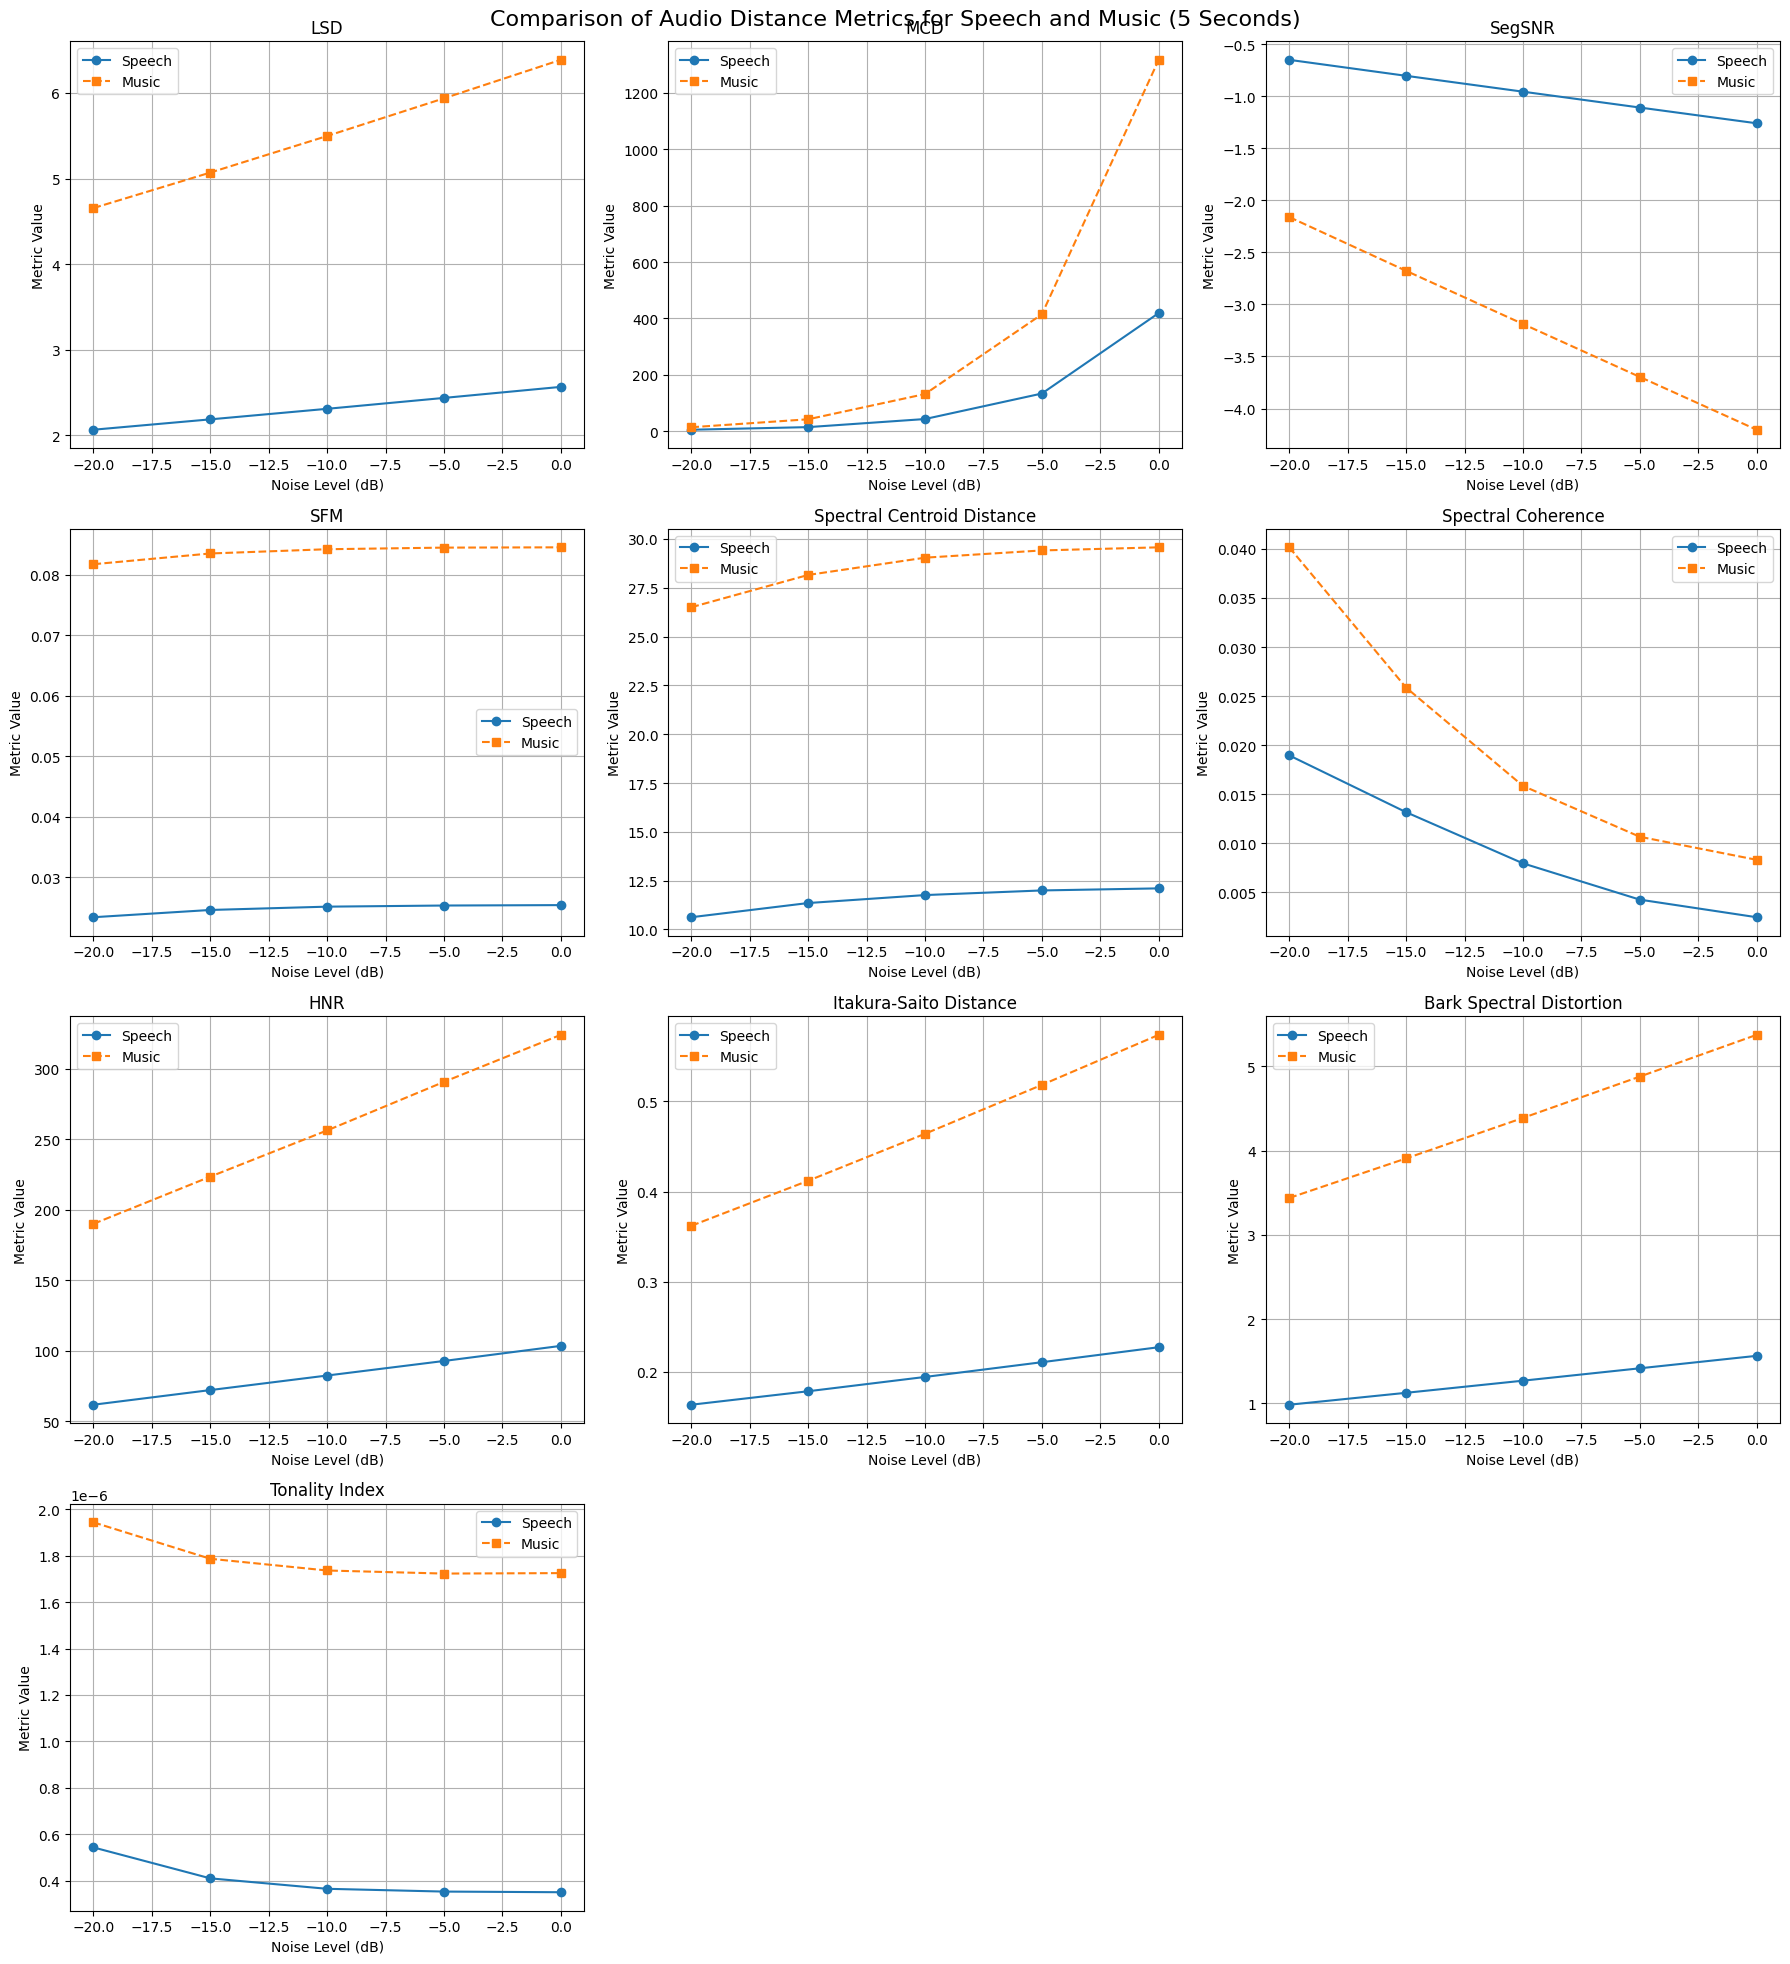

Time Complexity Table:
            Distance Function  Average Time (seconds)
0                         LSD                0.000736
1                         MCD                0.128233
2                      SegSNR                0.000502
3                         SFM                0.000570
4  Spectral Centroid Distance                0.000400
5          Spectral Coherence                0.003498
6                         HNR                0.000949
7      Itakura-Saito Distance                0.000553
8    Bark Spectral Distortion                0.001435
9              Tonality Index                0.000336


In [13]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        lsd = np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))
    return np.nan_to_num(lsd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        signal_power = np.sum(clean_frame**2)
        noise_power = np.sum(noise_frame**2)
        if noise_power == 0:
            snr = 0  # Avoid division by zero
        else:
            snr = 10 * np.log10(signal_power / noise_power)
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    if amean == 0:
        return 0  # Avoid division by zero
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / (np.sum(np.abs(X), axis=0) + 1e-10)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / (np.sum(np.abs(Y), axis=0) + 1e-10)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / (np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0)) + 1e-10)
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / (np.mean(np.abs(cepstrum)) + 1e-10)
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        isd = np.mean((X / Y) - np.log(X / Y) - 1)
    return np.nan_to_num(isd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X + 1e-10)
    Y_bark = librosa.amplitude_to_db(Y + 1e-10)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / (np.sum(spectrum)**2 + 1e-10)
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266:

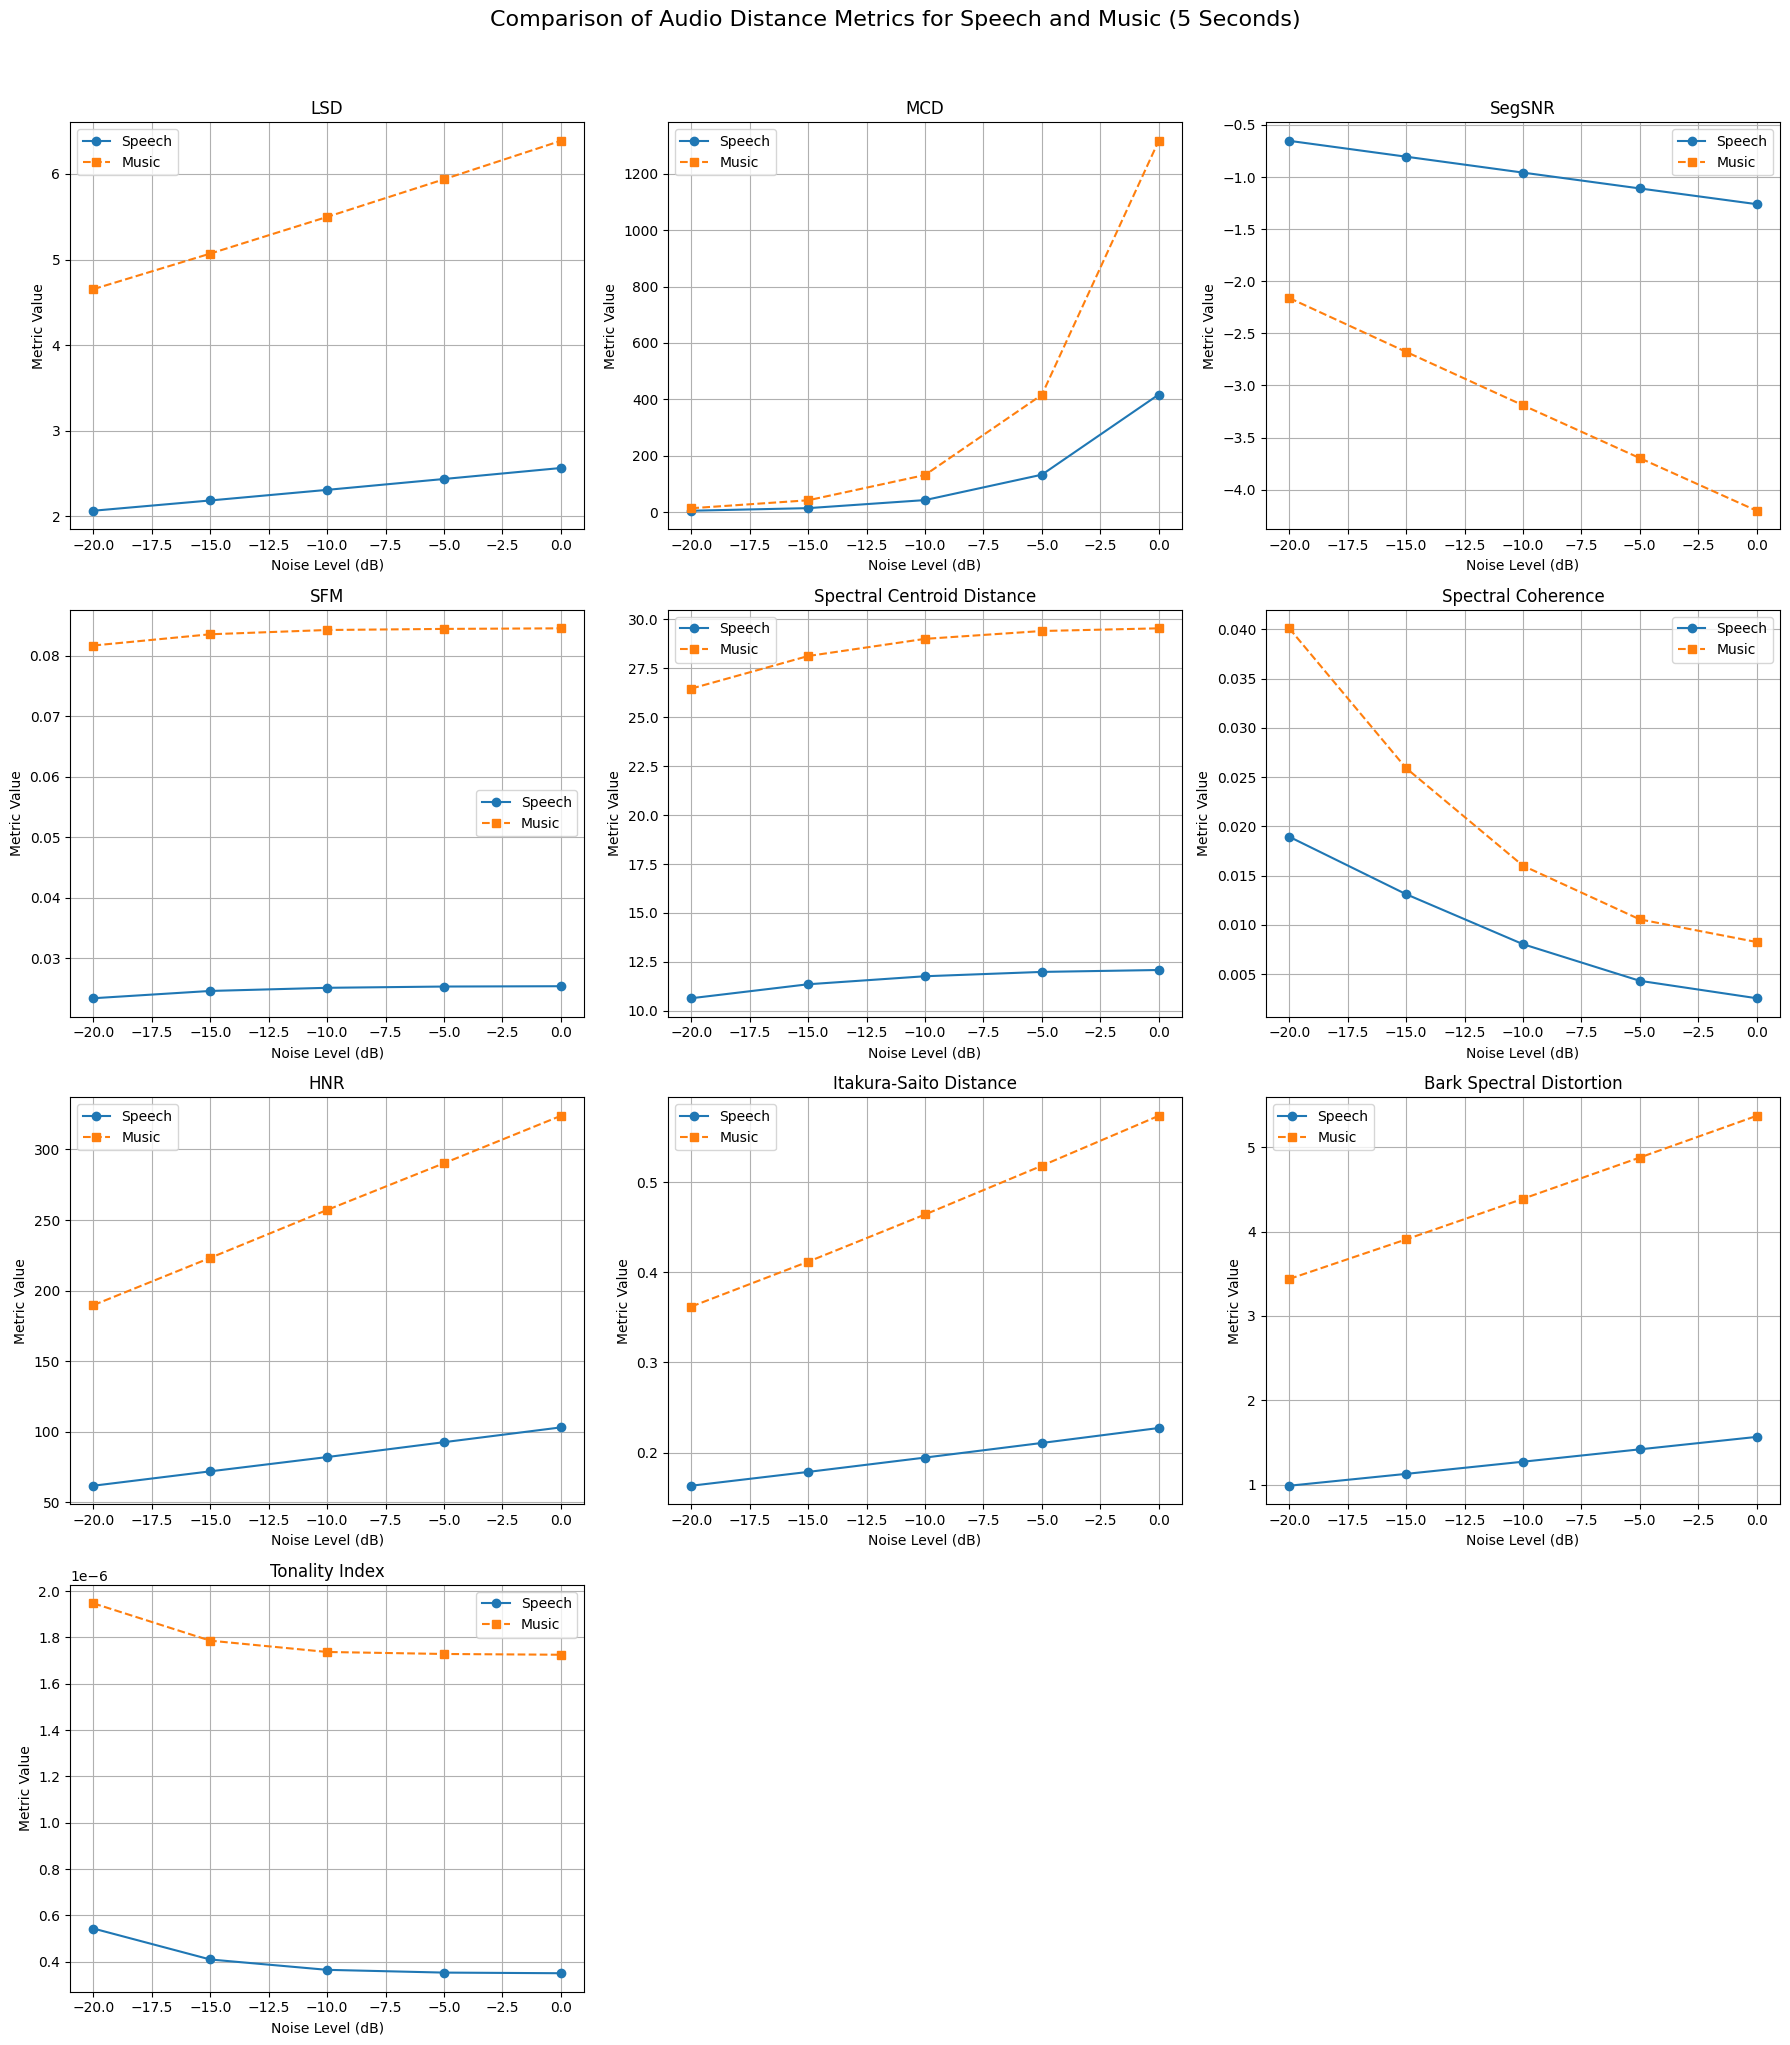

Time Complexity Table:
            Distance Function  Average Time (seconds)
0                         LSD                0.000766
1                         MCD                0.137512
2                      SegSNR                0.000485
3                         SFM                0.000589
4  Spectral Centroid Distance                0.000418
5          Spectral Coherence                0.003637
6                         HNR                0.001003
7      Itakura-Saito Distance                0.000549
8    Bark Spectral Distortion                0.001472
9              Tonality Index                0.000401


In [14]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        lsd = np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))
    return np.nan_to_num(lsd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        signal_power = np.sum(clean_frame**2)
        noise_power = np.sum(noise_frame**2)
        if noise_power == 0:
            snr = 0  # Avoid division by zero
        else:
            snr = 10 * np.log10(signal_power / noise_power)
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    if amean == 0:
        return 0  # Avoid division by zero
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / (np.sum(np.abs(X), axis=0) + 1e-10)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / (np.sum(np.abs(Y), axis=0) + 1e-10)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / (np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0)) + 1e-10)
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / (np.mean(np.abs(cepstrum)) + 1e-10)
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        isd = np.mean((X / Y) - np.log(X / Y) - 1)
    return np.nan_to_num(isd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X + 1e-10)
    Y_bark = librosa.amplitude_to_db(Y + 1e-10)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / (np.sum(spectrum)**2 + 1e-10)
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16, y=1.02)  # Adjust y for title spacing

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between subplots and figure title
fig.subplots_adjust(top=0.92)  # Increase the top margin to make space for the title

plt.tight_layout()
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 216, using nperseg = 216
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:1240: UserWarning: nperseg = 256 is greater than input length  = 209, using nperseg = 209
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266:

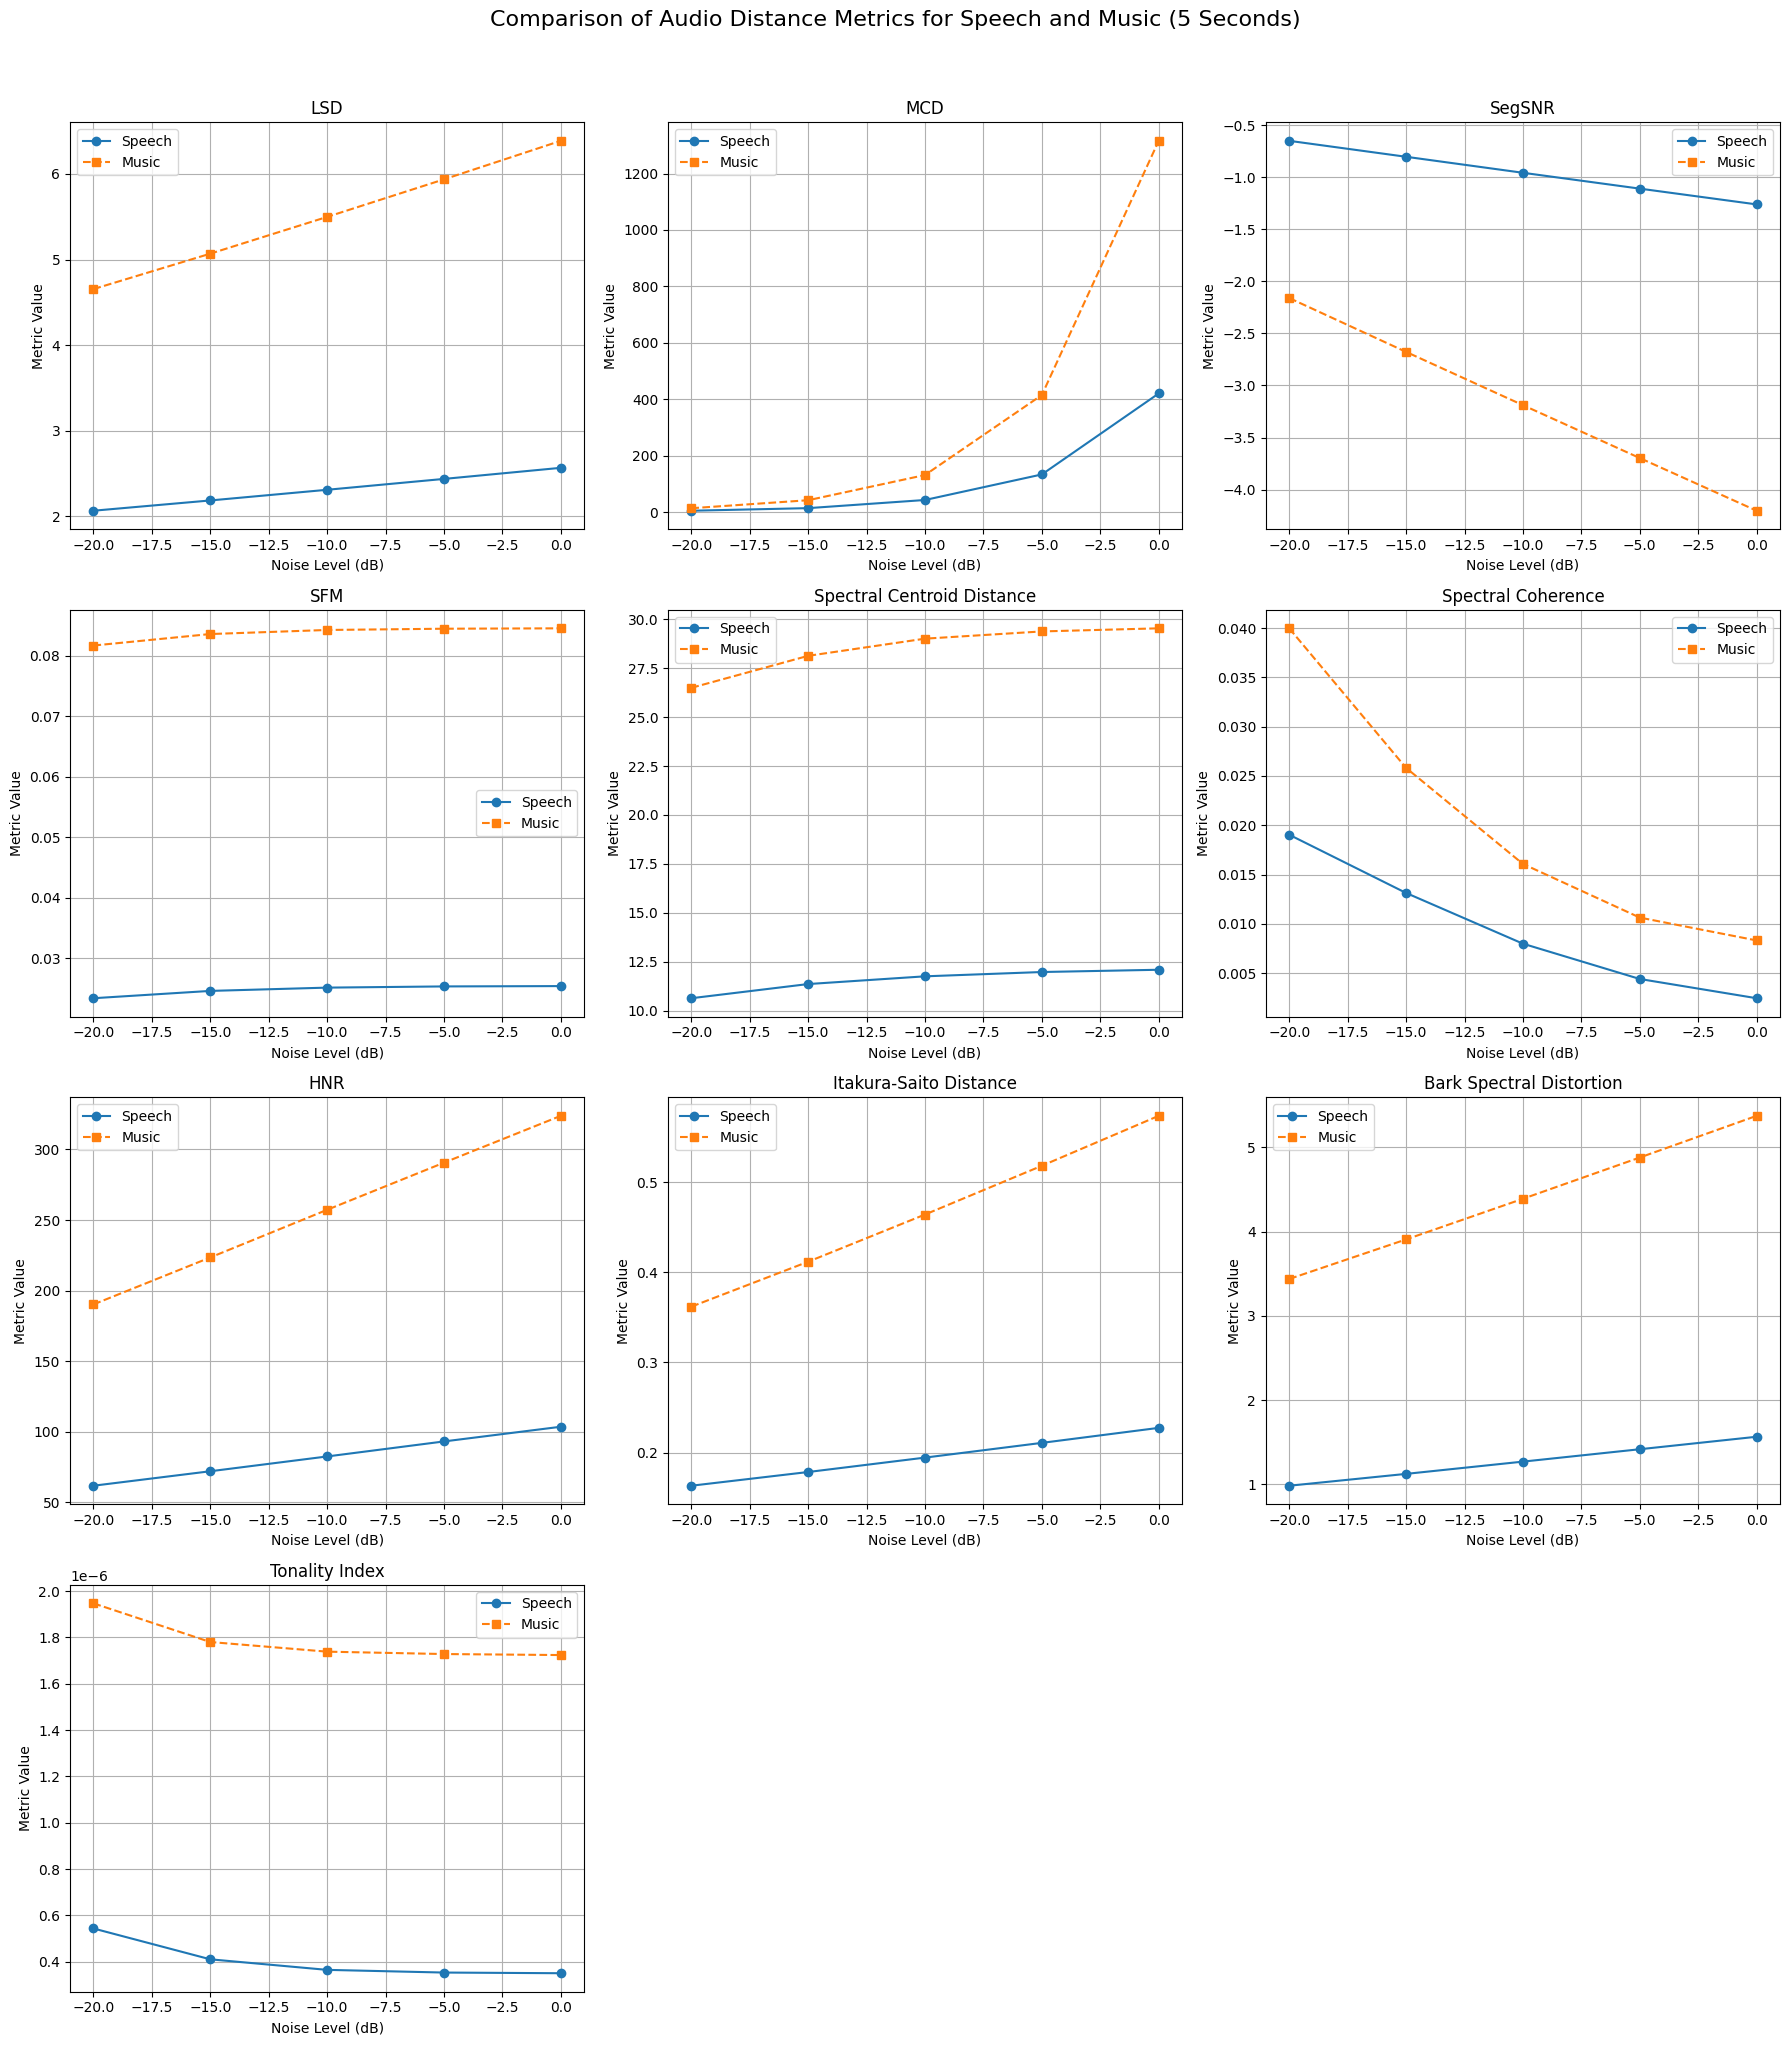

Time Complexity Table:
            Distance Function  Average Time (seconds)
0                         LSD                0.000681
1                         MCD                0.159003
2                      SegSNR                0.000452
3                         SFM                0.000476
4  Spectral Centroid Distance                0.000341
5          Spectral Coherence                0.003026
6                         HNR                0.000802
7      Itakura-Saito Distance                0.000496
8    Bark Spectral Distortion                0.001359
9              Tonality Index                0.000313
Results saved to 'audio_metrics_results.xlsx'


In [15]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import stft
import time
import pandas as pd

# Define duration to test (in seconds)
duration = 5

# Number of signals
num_signals = 100

# Load the example speech signal
speech_signal, sr_speech = librosa.load(librosa.example('libri1'), sr=None)

# Split the speech signal into 100 different segments of 5 seconds each
segment_length = int(duration * sr_speech)
speech_segments = [speech_signal[i * segment_length:(i + 1) * segment_length] for i in range(num_signals)]

# Load the example music signal
music_signal, sr_music = librosa.load(librosa.example('brahms'), sr=None)

# Split the music signal into 100 different segments of 5 seconds each
segment_length_music = int(duration * sr_music)
music_segments = [music_signal[i * segment_length_music:(i + 1) * segment_length_music] for i in range(num_signals)]

# Initialize dictionaries to store results for speech and music
results_speech = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

results_music = {
    'LSD': [],
    'MCD': [],
    'SegSNR': [],
    'SFM': [],
    'Spectral Centroid Distance': [],
    'Spectral Coherence': [],
    'HNR': [],
    'Itakura-Saito Distance': [],
    'Bark Spectral Distortion': [],
    'Tonality Index': []
}

# Define noise levels (in dB)
noise_levels = np.arange(-20, 1, 5)  # From -20 dB to 0 dB in steps of 5 dB

# Function to compute Log Spectral Distance (LSD)
def log_spectral_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        lsd = np.sqrt(np.mean((10 * np.log10((X**2) / (Y**2 + 1e-10)))**2))
    return np.nan_to_num(lsd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Mel-Cepstral Distortion (MCD)
def mel_cepstral_distortion(X, Y, n_mels=20):
    X_mel = librosa.feature.melspectrogram(y=X, sr=sr_speech, n_mels=n_mels)
    Y_mel = librosa.feature.melspectrogram(y=Y, sr=sr_speech, n_mels=n_mels)
    return np.mean(np.abs(X_mel - Y_mel))

# Function to compute Segmental Signal-to-Noise Ratio (SegSNR)
def segmental_snr(clean, noisy, frame_size=256, overlap=128):
    snr_segments = []
    for i in range(0, len(clean) - frame_size, frame_size - overlap):
        clean_frame = clean[i:i+frame_size]
        noisy_frame = noisy[i:i+frame_size]
        noise_frame = noisy_frame - clean_frame
        signal_power = np.sum(clean_frame**2)
        noise_power = np.sum(noise_frame**2)
        if noise_power == 0:
            snr = 0  # Avoid division by zero
        else:
            snr = 10 * np.log10(signal_power / noise_power)
        snr_segments.append(snr)
    return np.mean(snr_segments)

# Function to compute Spectral Flatness Measure (SFM)
def spectral_flatness_measure(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    gmean = np.exp(np.mean(np.log(spectrum + 1e-10)))
    amean = np.mean(spectrum)
    if amean == 0:
        return 0  # Avoid division by zero
    return gmean / amean

# Function to compute Spectral Centroid Distance
def spectral_centroid_distance(X, Y):
    centroid_X = np.sum(np.arange(X.shape[0])[:, np.newaxis] * np.abs(X), axis=0) / (np.sum(np.abs(X), axis=0) + 1e-10)
    centroid_Y = np.sum(np.arange(Y.shape[0])[:, np.newaxis] * np.abs(Y), axis=0) / (np.sum(np.abs(Y), axis=0) + 1e-10)
    return np.mean(np.abs(centroid_X - centroid_Y))

# Function to compute Spectral Coherence
def spectral_coherence(X, Y):
    _, _, Pxx = stft(X)
    _, _, Pyy = stft(Y)
    Pxy = np.abs(np.mean(Pxx * np.conj(Pyy), axis=0))
    coherence = Pxy / (np.sqrt(np.mean(np.abs(Pxx)**2, axis=0) * np.mean(np.abs(Pyy)**2, axis=0)) + 1e-10)
    return np.mean(coherence)

# Function to compute Harmonic-to-Noise Ratio (HNR)
def harmonic_to_noise_ratio(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    cepstrum = np.fft.ifft(np.log(np.abs(np.fft.fft(signal)) + 1e-10))
    hnr = np.max(np.abs(cepstrum)) / (np.mean(np.abs(cepstrum)) + 1e-10)
    return hnr

# Function to compute Itakura-Saito Distance
def itakura_saito_distance(X, Y):
    with np.errstate(divide='ignore', invalid='ignore'):
        isd = np.mean((X / Y) - np.log(X / Y) - 1)
    return np.nan_to_num(isd, nan=0.0, posinf=0.0, neginf=0.0)

# Function to compute Bark Spectral Distortion (BSD)
def bark_spectral_distortion(X, Y):
    X_bark = librosa.amplitude_to_db(X + 1e-10)
    Y_bark = librosa.amplitude_to_db(Y + 1e-10)
    return np.mean(np.abs(X_bark - Y_bark))

# Function to compute Tonality Index
def tonality_index(signal):
    if len(signal) == 0:
        return 0  # Return 0 for empty signals
    spectrum = np.abs(np.fft.fft(signal))
    tonal = np.sum(spectrum**2) / (np.sum(spectrum)**2 + 1e-10)
    return tonal

# Define distance functions dictionary
distance_functions = {
    'LSD': log_spectral_distance,
    'MCD': mel_cepstral_distortion,
    'SegSNR': segmental_snr,
    'SFM': spectral_flatness_measure,
    'Spectral Centroid Distance': spectral_centroid_distance,
    'Spectral Coherence': spectral_coherence,
    'HNR': harmonic_to_noise_ratio,
    'Itakura-Saito Distance': itakura_saito_distance,
    'Bark Spectral Distortion': bark_spectral_distortion,
    'Tonality Index': tonality_index
}

# Initialize dictionary to store time complexities
time_complexities = {metric: [] for metric in distance_functions.keys()}

# Loop through 100 signals
for signal_idx in range(num_signals):
    # Use a different segment of the speech signal
    speech_signal_segment = speech_segments[signal_idx]

    # Use a different segment of the music signal
    music_signal_segment = music_segments[signal_idx]

    # Resample music signal to match speech signal's sample rate
    if sr_speech != sr_music:
        music_signal_segment = librosa.resample(music_signal_segment, orig_sr=sr_music, target_sr=sr_speech)

    # Add noise and compute metrics for speech signal
    for noise_level in noise_levels:
        # Add noise to the speech signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(speech_signal_segment))
        noisy_speech = speech_signal_segment + noise

        # Compute STFTs
        clean_stft_speech = np.abs(librosa.stft(speech_signal_segment))
        noisy_stft_speech = np.abs(librosa.stft(noisy_speech))

        # Compute metrics for speech
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_speech)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_speech, noisy_stft_speech)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_speech[metric].append(result)

    # Add noise and compute metrics for music signal
    for noise_level in noise_levels:
        # Add noise to the music signal
        noise = np.random.normal(0, 10**(noise_level / 20), len(music_signal_segment))
        noisy_music = music_signal_segment + noise

        # Compute STFTs
        clean_stft_music = np.abs(librosa.stft(music_signal_segment))
        noisy_stft_music = np.abs(librosa.stft(noisy_music))

        # Compute metrics for music
        for metric, func in distance_functions.items():
            if metric in ['SFM', 'HNR', 'Tonality Index']:
                # Functions that take only one argument (noisy signal)
                start_time = time.time()
                result = func(noisy_music)
                end_time = time.time()
            else:
                # Functions that take two arguments (clean and noisy signals)
                start_time = time.time()
                result = func(clean_stft_music, noisy_stft_music)
                end_time = time.time()
            time_complexities[metric].append(end_time - start_time)
            results_music[metric].append(result)

# Average the results for each metric
for metric in results_speech.keys():
    results_speech[metric] = np.mean(np.array(results_speech[metric]).reshape(num_signals, len(noise_levels)), axis=0)
    results_music[metric] = np.mean(np.array(results_music[metric]).reshape(num_signals, len(noise_levels)), axis=0)

# Plot comparison of distance functions at different noise levels
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Comparison of Audio Distance Metrics for Speech and Music (5 Seconds)', fontsize=16, y=1.02)  # Adjust y for title spacing

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, (metric, _) in enumerate(results_speech.items()):
    axes[i].plot(noise_levels, results_speech[metric], marker='o', linestyle='-', label='Speech')
    axes[i].plot(noise_levels, results_music[metric], marker='s', linestyle='--', label='Music')
    axes[i].set_title(metric)
    axes[i].set_xlabel('Noise Level (dB)')
    axes[i].set_ylabel('Metric Value')
    axes[i].legend()
    axes[i].grid()

# Remove empty subplots (if any)
for j in range(len(results_speech), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between subplots and figure title
fig.subplots_adjust(top=0.92)  # Increase the top margin to make space for the title

plt.tight_layout()
plt.show()

# Create a table for time complexity
time_complexity_table = pd.DataFrame({
    'Distance Function': list(time_complexities.keys()),
    'Average Time (seconds)': [np.mean(time_complexities[metric]) for metric in time_complexities.keys()]
})

print("Time Complexity Table:")
print(time_complexity_table)

# Save results to Excel
results_df_speech = pd.DataFrame(results_speech)
results_df_music = pd.DataFrame(results_music)

# Add noise levels as a column
results_df_speech['Noise Level (dB)'] = noise_levels
results_df_music['Noise Level (dB)'] = noise_levels

# Save to Excel
with pd.ExcelWriter('audio_metrics_results.xlsx') as writer:
    results_df_speech.to_excel(writer, sheet_name='Speech Results', index=False)
    results_df_music.to_excel(writer, sheet_name='Music Results', index=False)
    time_complexity_table.to_excel(writer, sheet_name='Time Complexity', index=False)

print("Results saved to 'audio_metrics_results.xlsx'")